# Pandas 데모 - Explarotary Data Analysis

## 라이브러리 import 및 설정

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings
from sklearn.model_selection import KFold

In [3]:
import numpy as np
import xgboost as xgb
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import plot_importance
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler, RobustScaler # 데이터 표준화

# lightgbm 모델
from lightgbm import LGBMClassifier, plot_importance

# normalization
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

#feature Selection
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_classif

In [4]:
rcParams['figure.figsize'] = (18, 9)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 데이터 다운로드

데이터는 [Dacon 단국대 소/중 데이터 분석 AI 경진대회 웹사이트](https://www.dacon.io/competitions/official/235638/data/)에서 다운로드 받아 `../input` 폴더에 저장.

In [5]:
!ls -alF ../../input/

total 287952
drwxr-xr-x 2 swcu swcu      4096  9월 23 11:38 ./
drwxrwxr-x 8 swcu swcu      4096  9월 24 17:19 ../
-rw-r--r-- 1 swcu swcu  47899736  9월 18 02:22 ecminer_standard_normal_outlier_train.csv
-rw-r--r-- 1 swcu swcu 132585197  9월 24 15:52 feature.csv
-rw-r--r-- 1 swcu swcu    720009  9월 23 11:34 lgbm_u_r_i_z_redshift_du_dg_dr_di_dz.csv
-rw-r--r-- 1 swcu swcu    800010  7월 26 13:35 sample_submission.csv
-rw-r--r-- 1 swcu swcu  17619545  9월 18 01:17 standard_normal_test.xlsx
-rw-r--r-- 1 swcu swcu  18936246  7월 26 13:35 test.csv
-rw-r--r-- 1 swcu swcu  76278443  7월 26 13:35 train.csv


In [6]:
data_dir = Path('../../input/')
trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
feature_file = data_dir / 'feature.csv'
sample_file = data_dir / 'sample_submission.csv'
sub_dir = Path('../../sub')
target_col = 'class'
seed = 42

In [7]:
algo_name = 'lgb'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

#feature_file = feature_dir / f'{feature_name}.csv'
sub_file = sub_dir / f'{model_name}.csv'

## EDA

In [8]:
trn = pd.read_csv(trn_file, index_col=0)
print(trn.shape)
trn.head()

(320000, 19)


,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
id,,,,,,,,,,,,,,,,,,,
0,23.2640,20.3368,19.0095,17.6724,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,18,18,1.1898,1.1907,1.1890,1.1894,1.1902,0
1,15.0521,14.0620,13.4524,13.2684,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1,1,1.2533,1.2578,1.2488,1.2510,1.2555,1
2,16.7864,15.8254,15.5363,15.3935,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,2,2,1.0225,1.0241,1.0210,1.0217,1.0233,0
3,25.6606,21.1887,20.2212,19.8949,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,4,3,1.2054,1.2061,1.2049,1.2051,1.2057,0
4,24.4534,20.6992,19.0424,18.3242,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,13,12,1.1939,1.1943,1.1937,1.1938,1.1941,0


## 데이터 개요

In [9]:
trn.describe()

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
count,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,3.2000e+05,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000
mean,19.8524,18.3768,17.7358,17.1742,16.8752,5.8308e-02,19.6289,18.2271,17.6154,17.1523,16.8693,6.3327,6.1388,1.1758,1.1765,1.1751,1.1754,1.1761,1.1163
std,1.9455,31.1108,1.4662,52.5615,57.1463,5.7546e-01,1.9236,17.7866,1.4730,25.0758,35.4365,8.8811,8.5516,0.1163,0.1181,0.1147,0.1155,0.1172,0.9235
min,-17.6875,-17555.3656,7.7314,-23955.8178,-23955.8178,-1.6605e+02,-42.8375,-9999.0000,-16.3802,-9999.0000,-9999.0000,1.0000,1.0000,1.0001,1.0000,1.0002,1.0001,1.0000,0.0000
25%,18.7242,17.4749,16.8772,16.5239,16.2889,3.5580e-05,18.5636,17.3484,16.7871,16.4530,16.2341,1.0000,1.0000,1.0882,1.0884,1.0878,1.0880,1.0883,0.0000
50%,19.4194,18.1405,17.5258,17.1497,16.9176,4.7129e-02,19.2646,18.0224,17.4434,17.0874,16.8694,2.0000,2.0000,1.1793,1.1792,1.1794,1.1794,1.1793,1.0000
75%,20.4321,19.0732,18.4281,18.0074,17.7289,9.4597e-02,20.1976,18.8884,18.2911,17.9070,17.6557,5.0000,5.0000,1.2275,1.2260,1.2292,1.2286,1.2268,2.0000
max,58.6233,46.3383,72.0097,50.1641,52.6127,6.2323e+01,30.7779,30.6132,31.9572,32.0162,30.7813,44.0000,42.0000,2.0508,2.0803,2.0221,2.0363,2.0654,2.0000


In [10]:
trn.dtypes

u            float64
g            float64
r            float64
i            float64
z            float64
redshift     float64
dered_u      float64
dered_g      float64
dered_r      float64
dered_i      float64
dered_z      float64
nObserve       int64
nDetect        int64
airmass_u    float64
airmass_g    float64
airmass_r    float64
airmass_i    float64
airmass_z    float64
class          int64
dtype: object

In [11]:
for i in trn.columns:
    print(i, len(trn.loc[trn[i]<0]))


u 3
g 4
r 0
i 4
z 9
redshift 70876
dered_u 8
dered_g 9
dered_r 6
dered_i 7
dered_z 8
nObserve 0
nDetect 0
airmass_u 0
airmass_g 0
airmass_r 0
airmass_i 0
airmass_z 0
class 0


In [12]:
col = ['u', 'g', 'r', 'i', 'z', 'dered_u', 'dered_g', 
      'dered_r', 'dered_i', 'dered_z']
trn1 = trn.copy()
for i in col:
    trn1 = trn1[trn1[i] >=0]

trn1

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
id,,,,,,,,,,,,,,,,,,,
0,23.2640,20.3368,19.0095,17.6724,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,18,18,1.1898,1.1907,1.1890,1.1894,1.1902,0
1,15.0521,14.0620,13.4524,13.2684,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1,1,1.2533,1.2578,1.2488,1.2510,1.2555,1
2,16.7864,15.8254,15.5363,15.3935,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,2,2,1.0225,1.0241,1.0210,1.0217,1.0233,0
3,25.6606,21.1887,20.2212,19.8949,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,4,3,1.2054,1.2061,1.2049,1.2051,1.2057,0
4,24.4534,20.6992,19.0424,18.3242,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,13,12,1.1939,1.1943,1.1937,1.1938,1.1941,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319995,18.3656,17.2409,16.7739,16.4850,16.3404,5.1988e-02,18.1328,17.0406,16.6374,16.3861,16.2874,2,2,1.0930,1.0888,1.0973,1.0951,1.0909,2
319996,18.6856,17.6658,17.1904,16.8169,16.6367,8.7261e-02,18.5207,17.5131,17.0871,16.7436,16.6017,2,2,1.0517,1.0508,1.0526,1.0522,1.0513,1
319997,21.1890,18.4234,17.2956,16.9011,16.6841,-1.0148e-05,20.9890,18.3076,17.2152,16.8403,16.6355,31,30,1.1933,1.1941,1.1925,1.1929,1.1937,0


In [13]:
trn1.describe()

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
count,319978.0000,319978.0000,319978.0000,319978.0000,319978.0000,3.1998e+05,319978.0000,319978.0000,319978.0000,319978.0000,319978.0000,319978.0000,319978.0000,319978.0000,319978.0000,319978.0000,319978.0000,319978.0000,319978.0000
mean,19.8528,18.4320,17.7358,17.3043,17.0613,5.8309e-02,19.6301,18.2593,17.6161,17.2154,16.9947,6.3328,6.1390,1.1758,1.1765,1.1751,1.1754,1.1761,1.1163
std,1.9428,1.6591,1.4662,1.3198,1.3333,5.7548e-01,1.9072,1.6566,1.4665,1.3249,1.3233,8.8814,8.5519,0.1163,0.1181,0.1147,0.1155,0.1172,0.9235
min,2.2651,1.2383,7.7314,2.7492,5.1281,-1.6605e+02,0.7538,3.0828,6.0403,6.8561,7.2567,1.0000,1.0000,1.0001,1.0000,1.0002,1.0001,1.0000,0.0000
25%,18.7242,17.4749,16.8772,16.5239,16.2890,3.5580e-05,18.5637,17.3484,16.7873,16.4531,16.2342,1.0000,1.0000,1.0882,1.0884,1.0878,1.0880,1.0883,0.0000
50%,19.4195,18.1405,17.5258,17.1498,16.9177,4.7133e-02,19.2646,18.0224,17.4434,17.0874,16.8694,2.0000,2.0000,1.1793,1.1792,1.1794,1.1794,1.1793,1.0000
75%,20.4320,19.0729,18.4281,18.0075,17.7290,9.4600e-02,20.1976,18.8885,18.2912,17.9070,17.6556,5.0000,5.0000,1.2275,1.2260,1.2292,1.2286,1.2268,2.0000
max,58.6233,46.3383,72.0097,50.1641,52.6127,6.2323e+01,30.7779,30.6132,31.9572,32.0162,30.7813,44.0000,42.0000,2.0508,2.0803,2.0221,2.0363,2.0654,2.0000


u


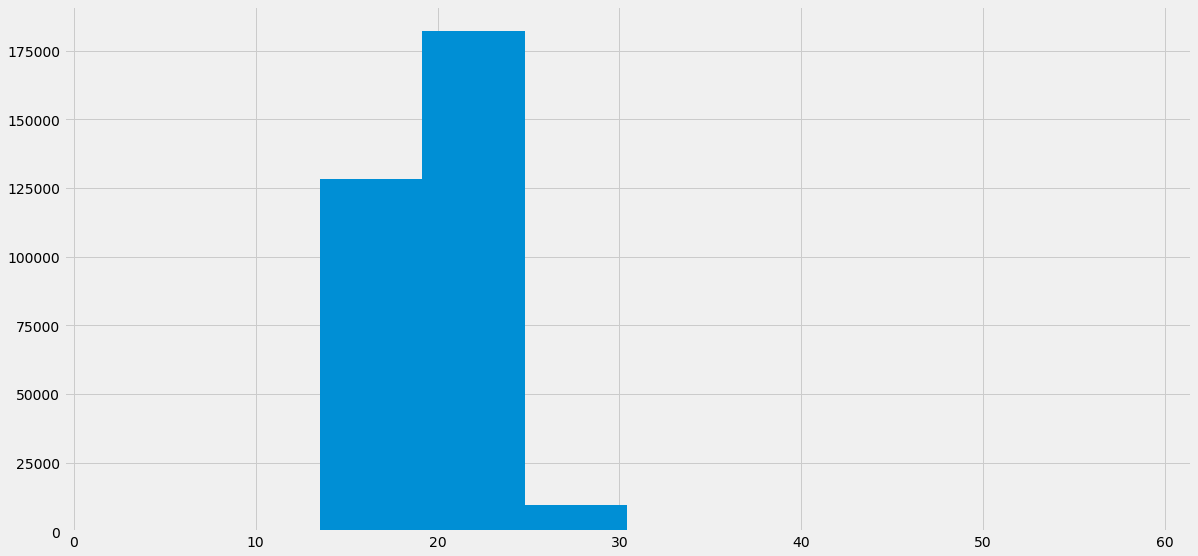

g


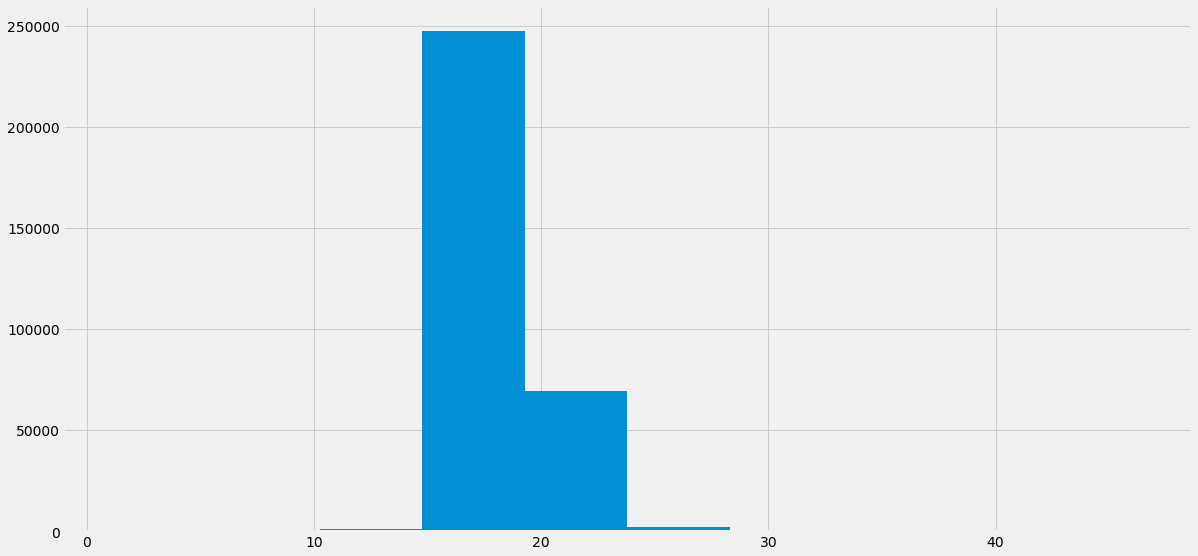

r


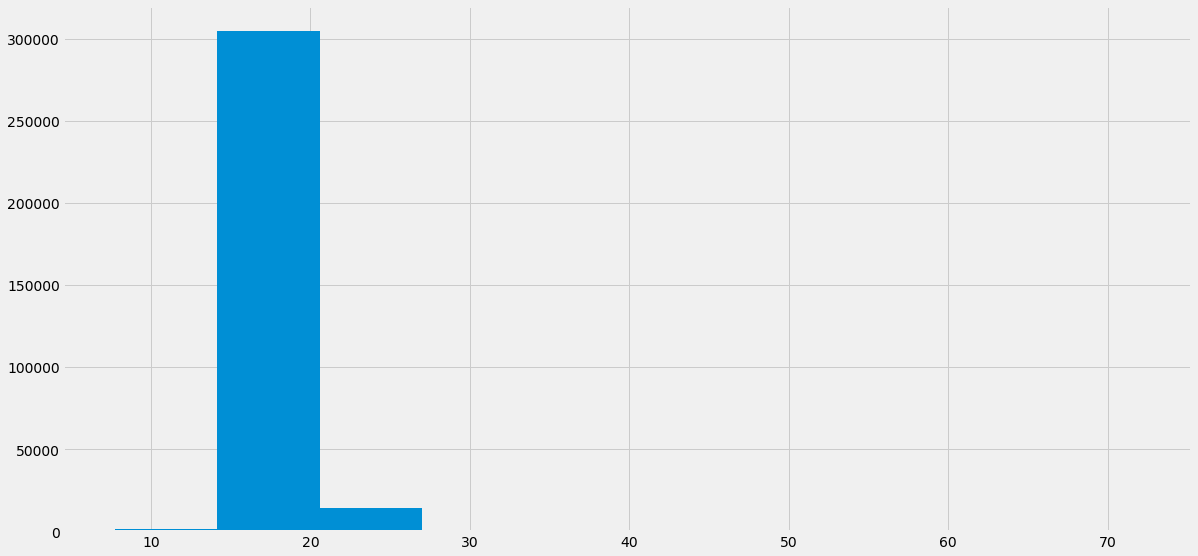

i


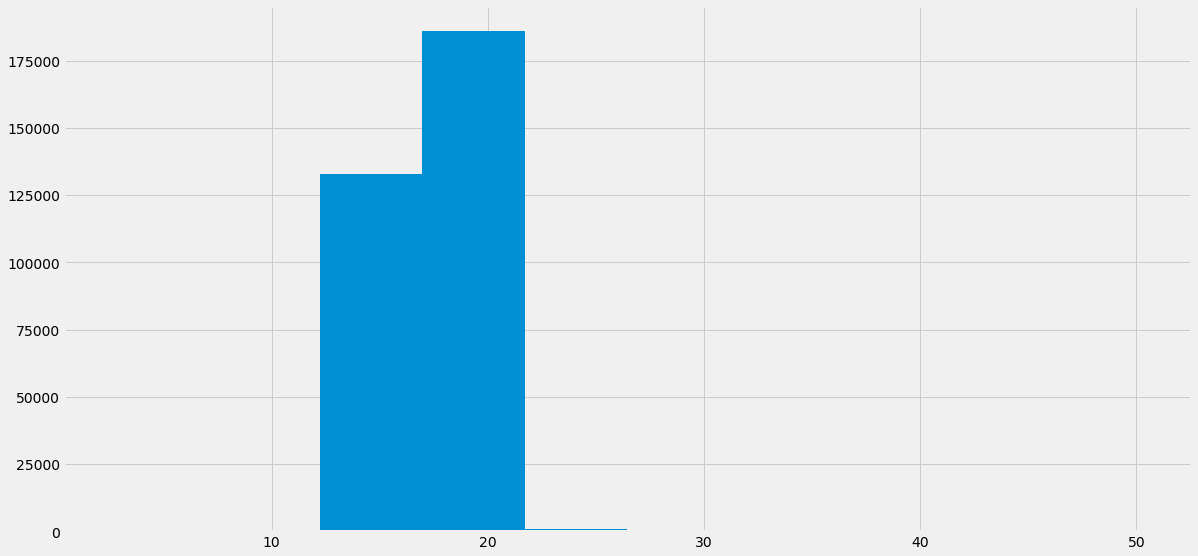

z


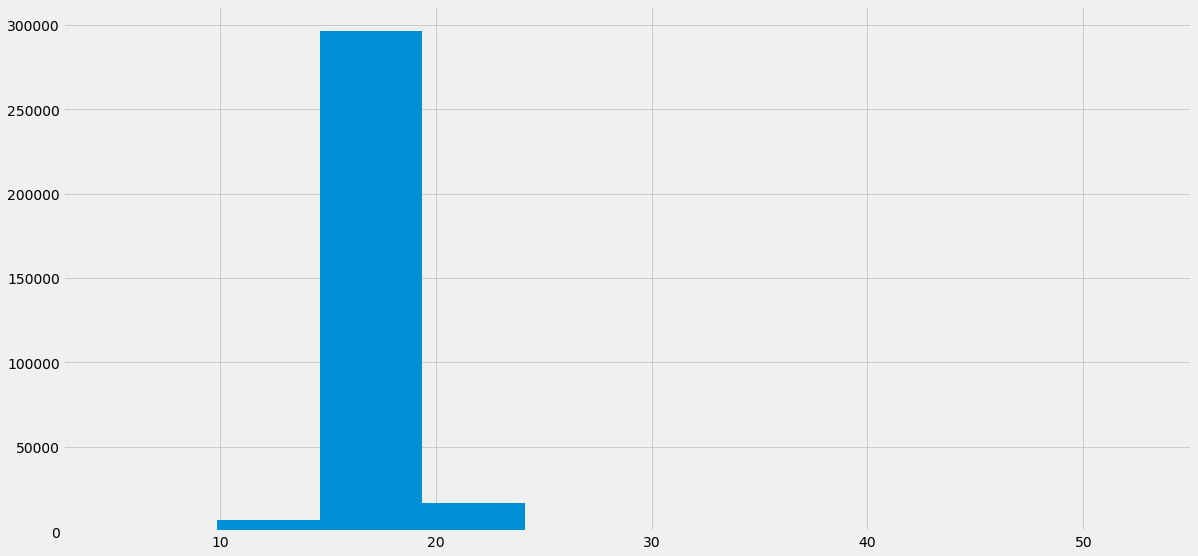

redshift


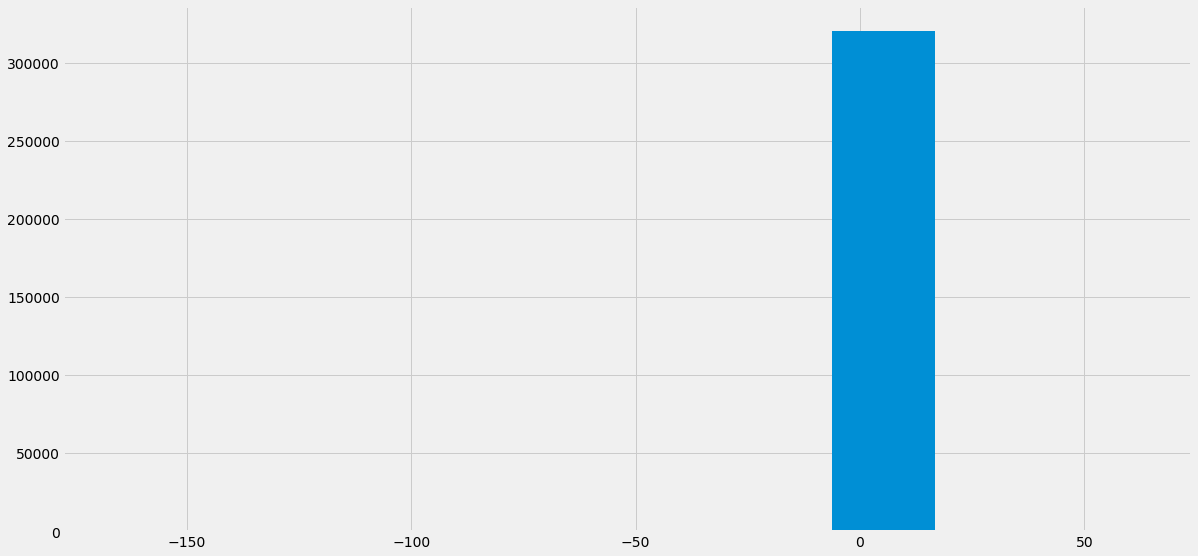

dered_u


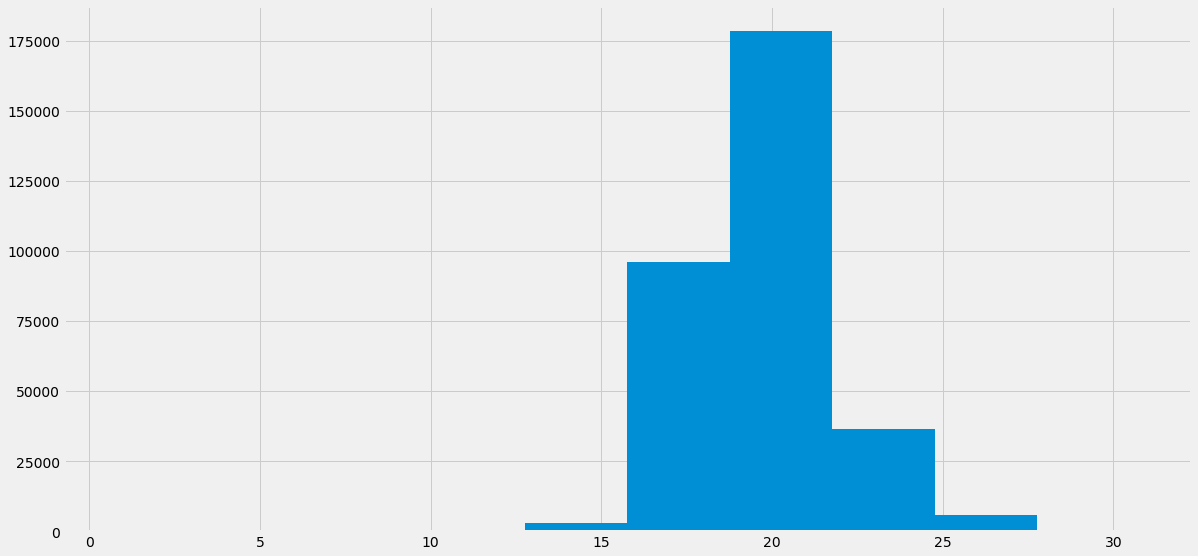

dered_g


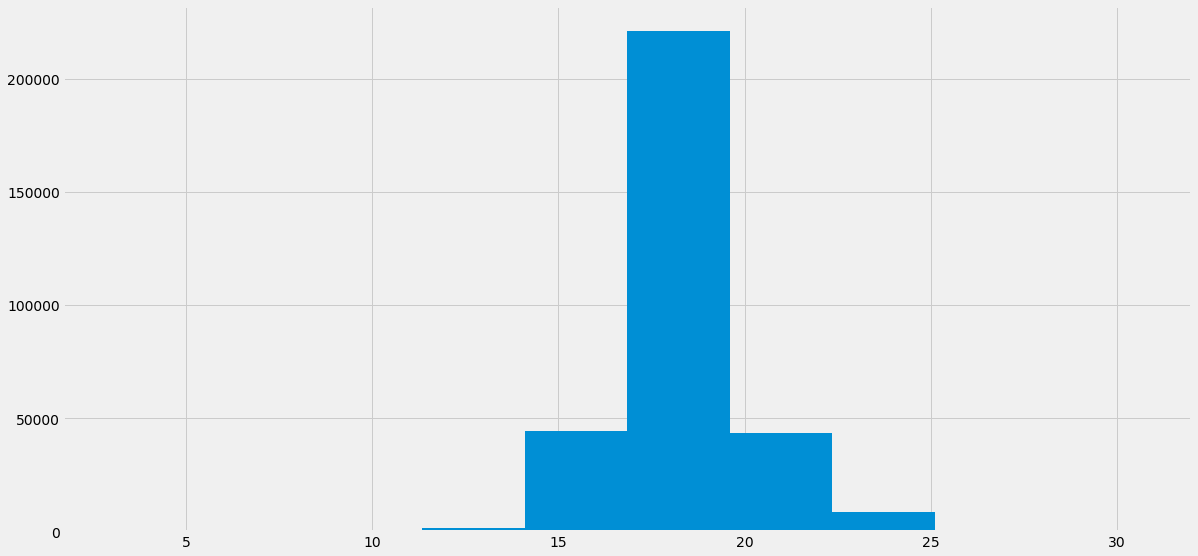

dered_r


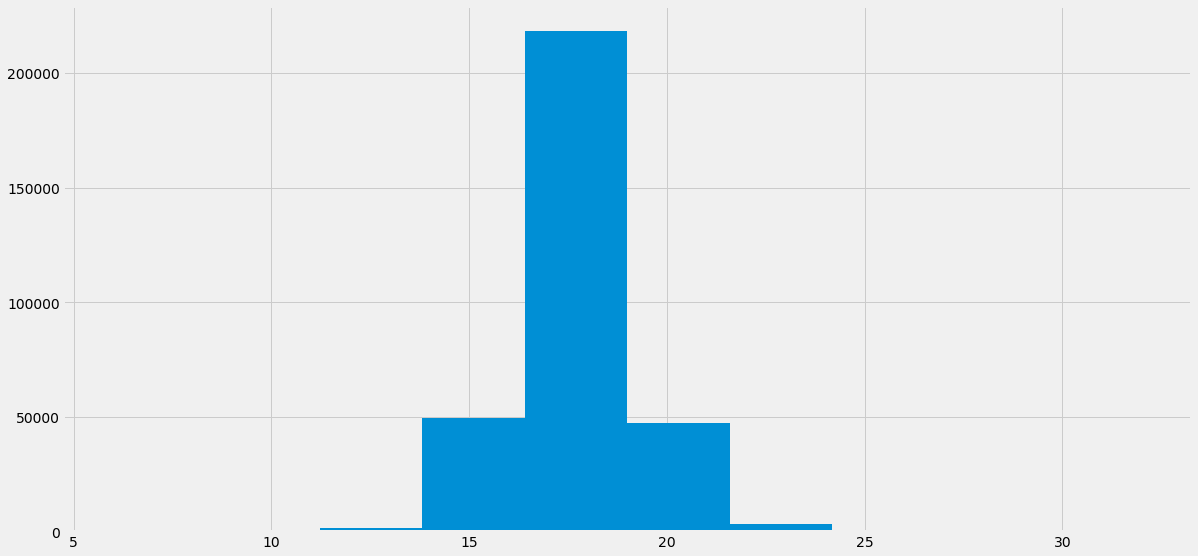

dered_i


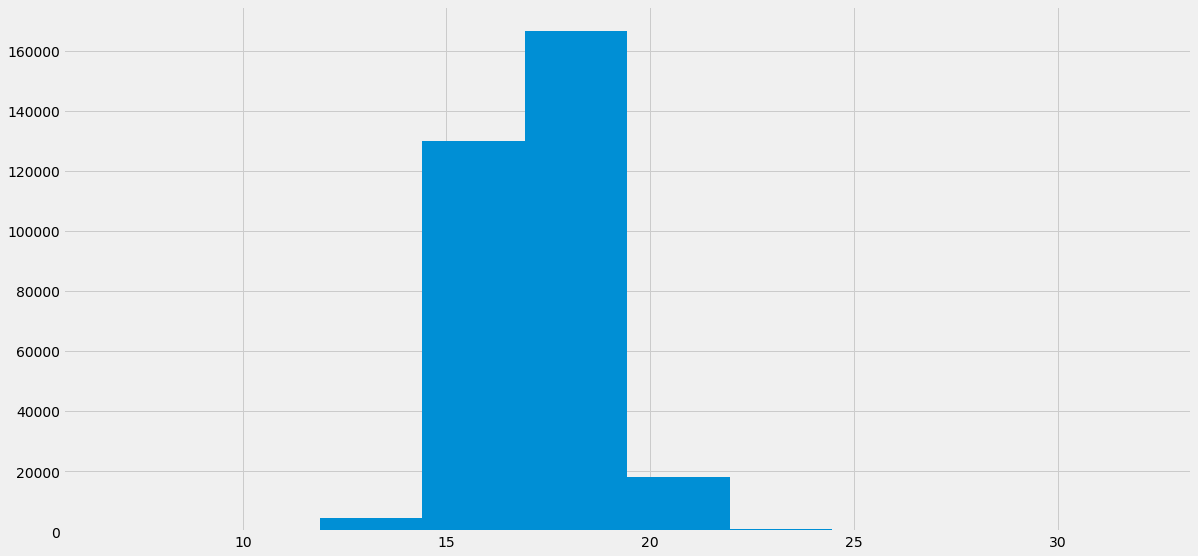

dered_z


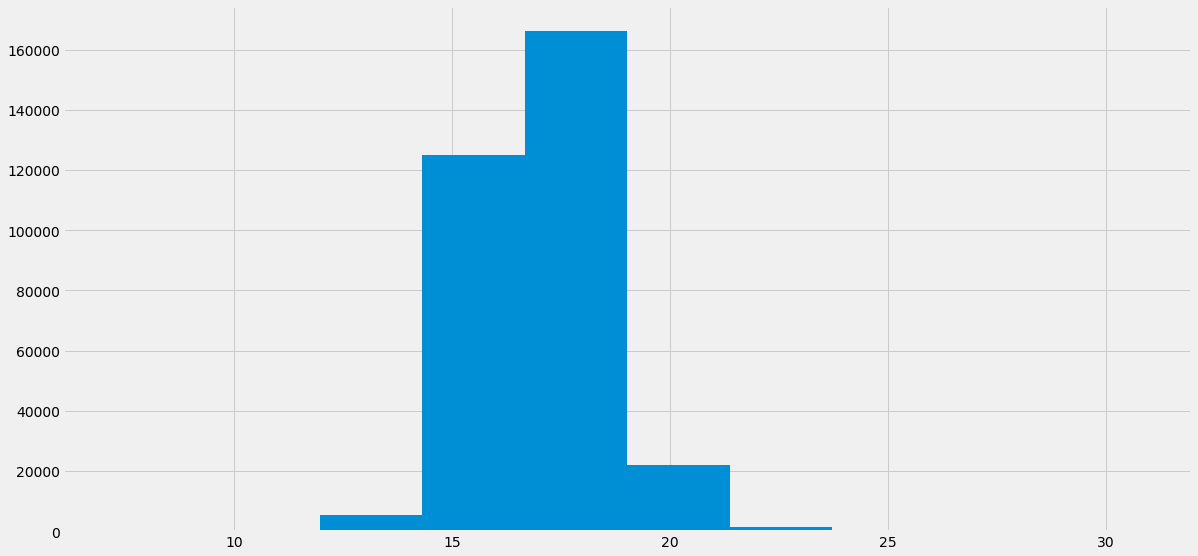

nObserve


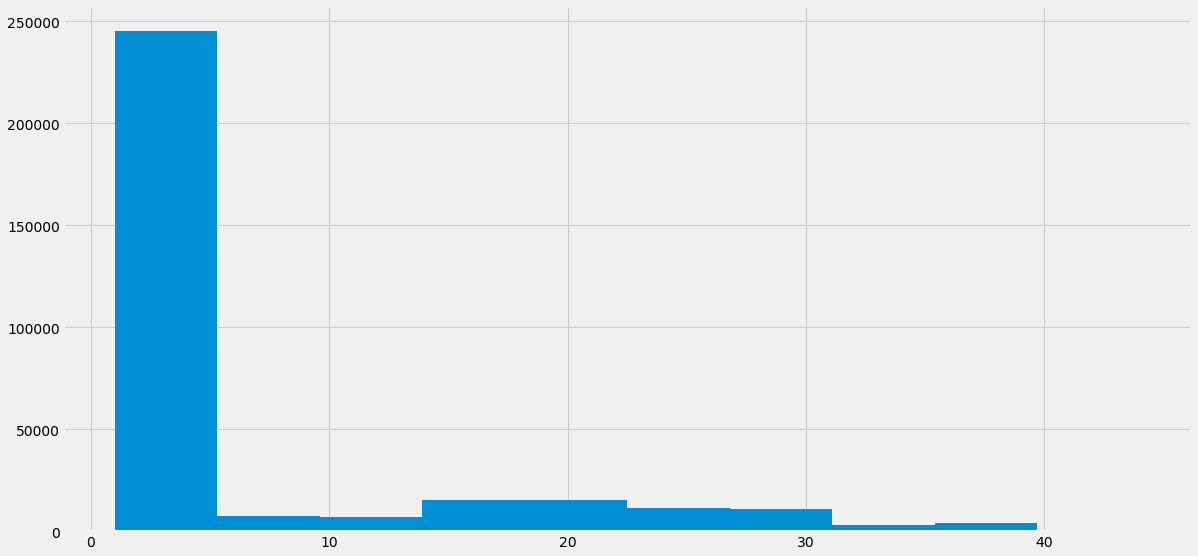

nDetect


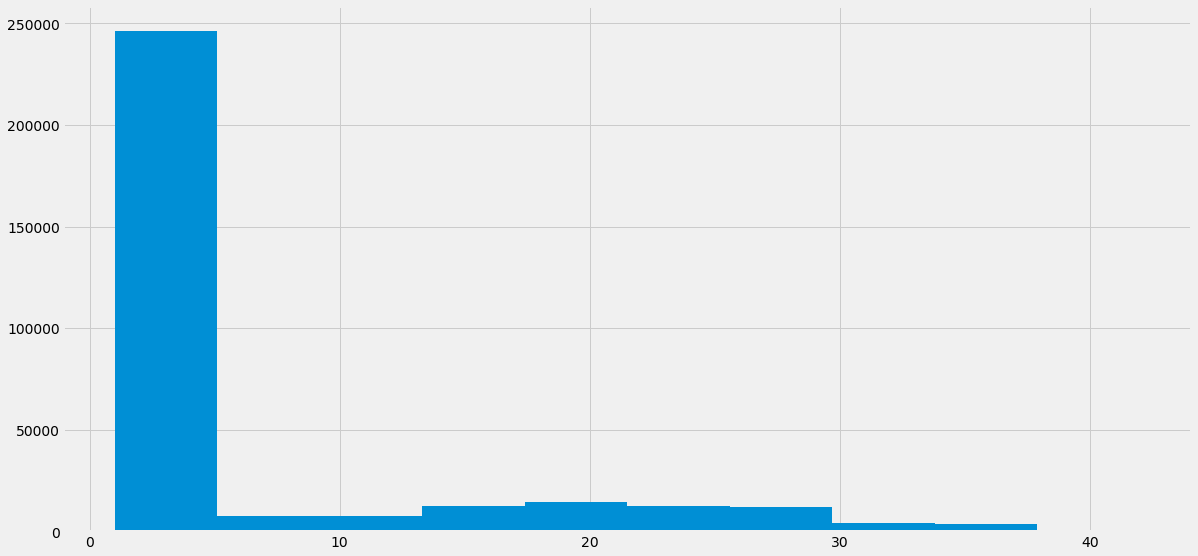

airmass_u


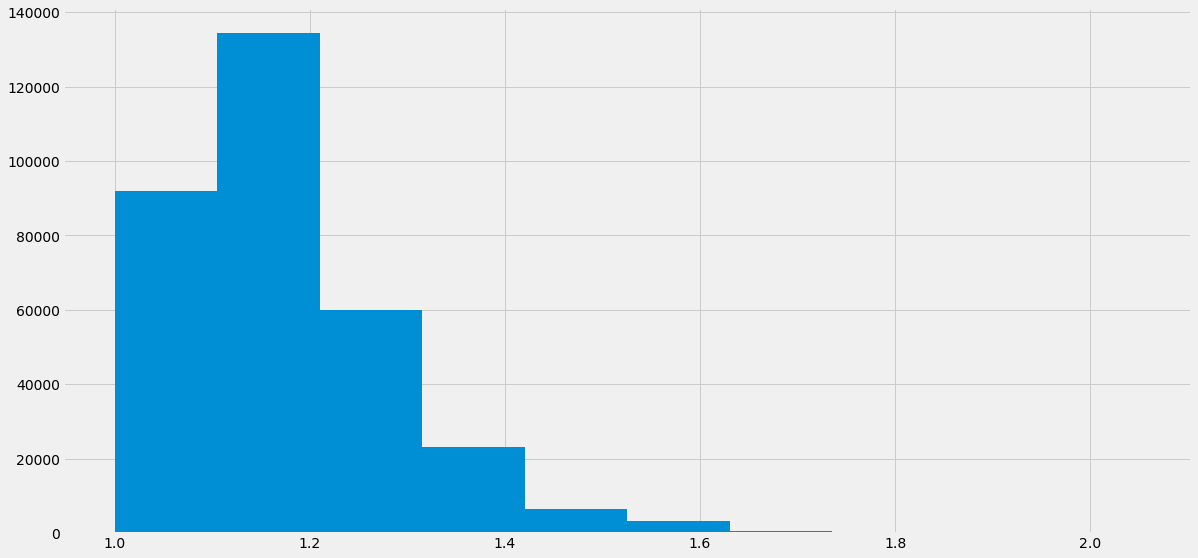

airmass_g


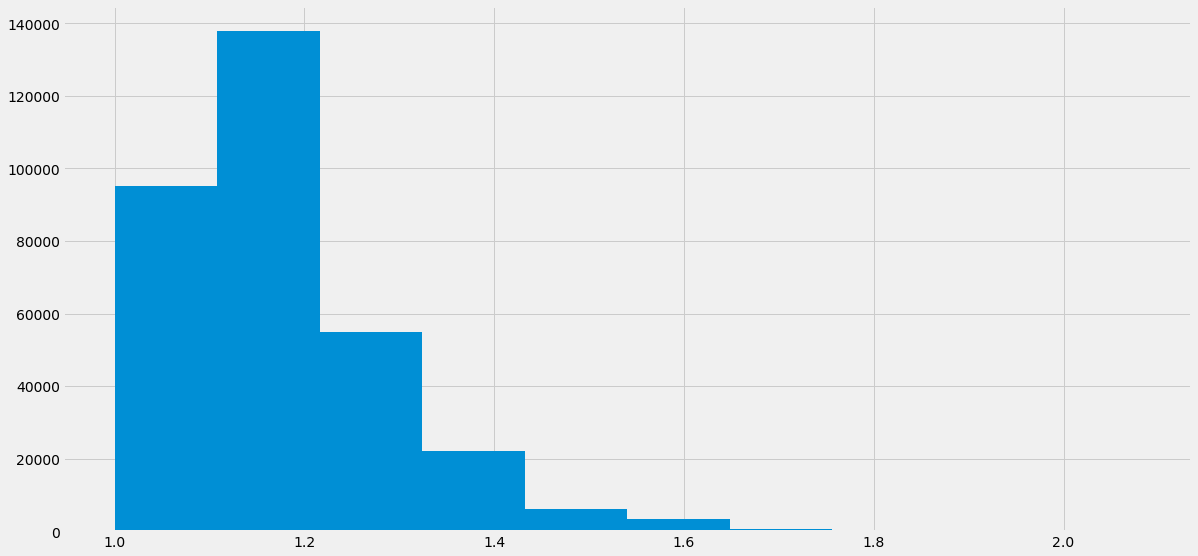

airmass_r


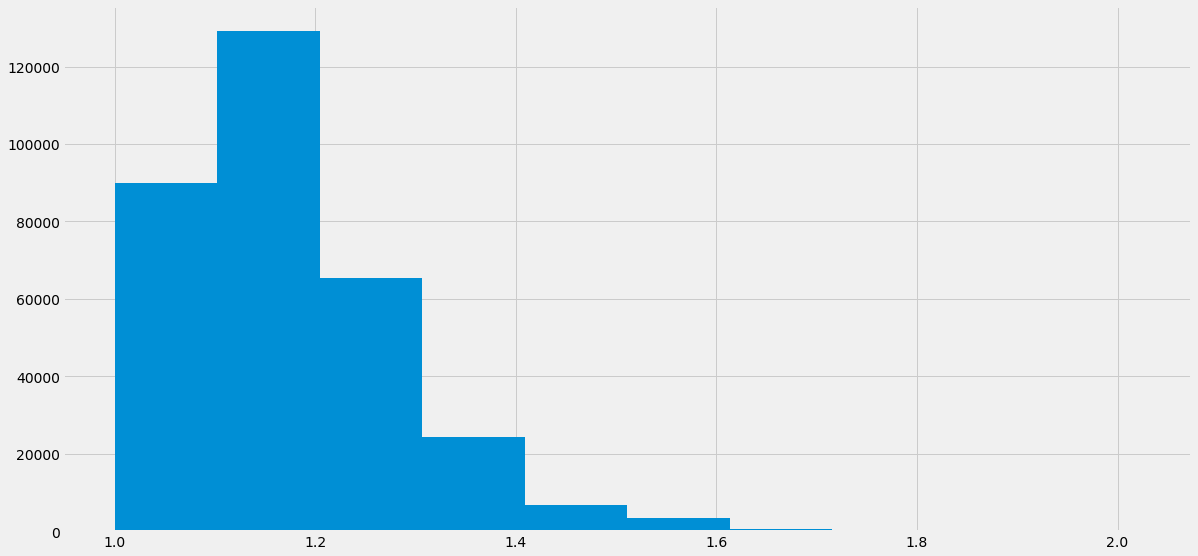

airmass_i


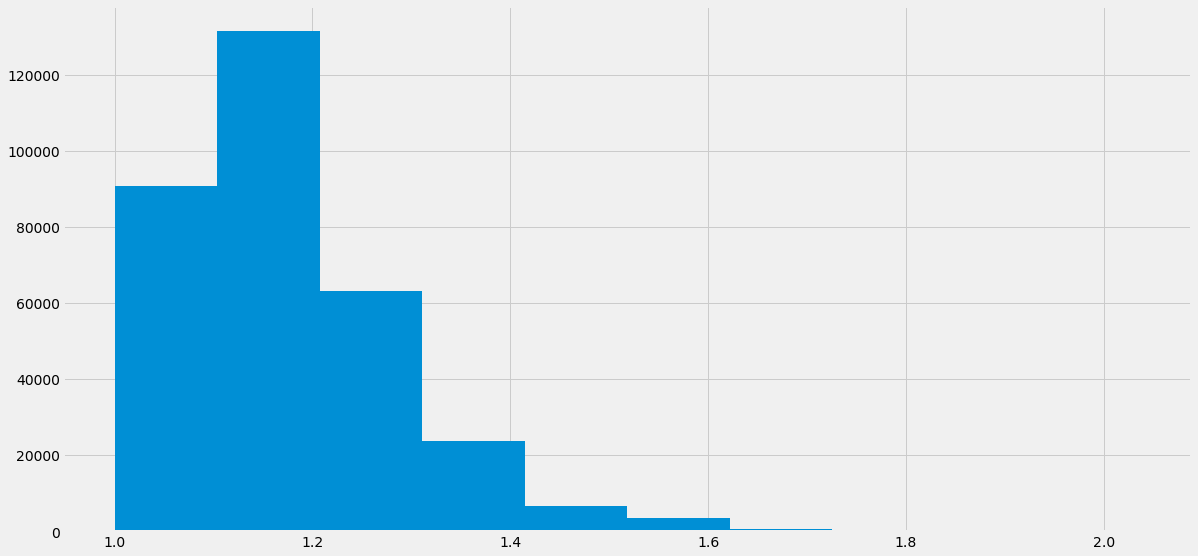

airmass_z


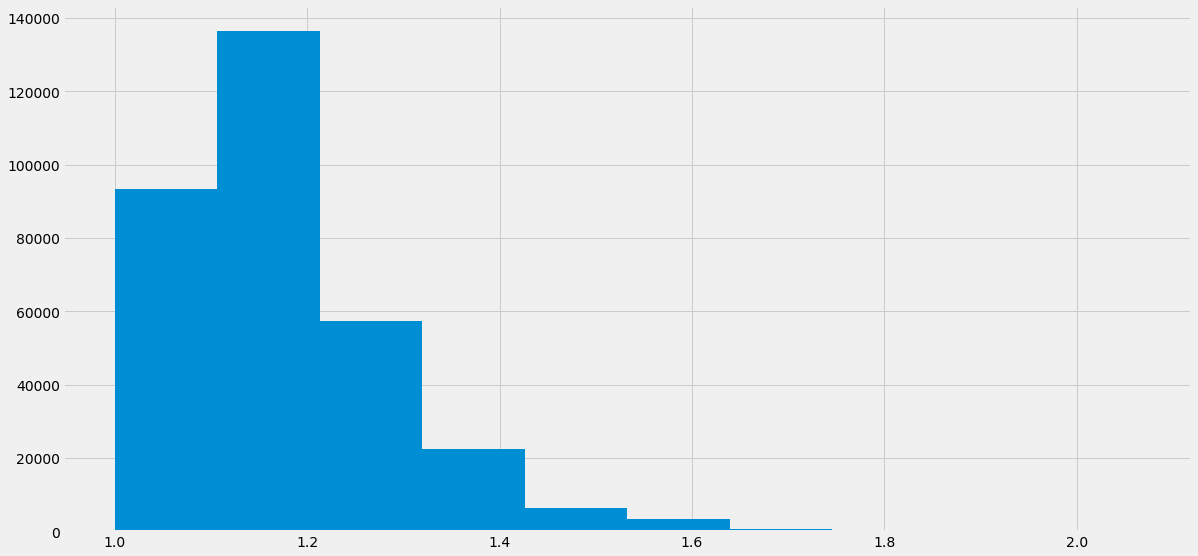

class


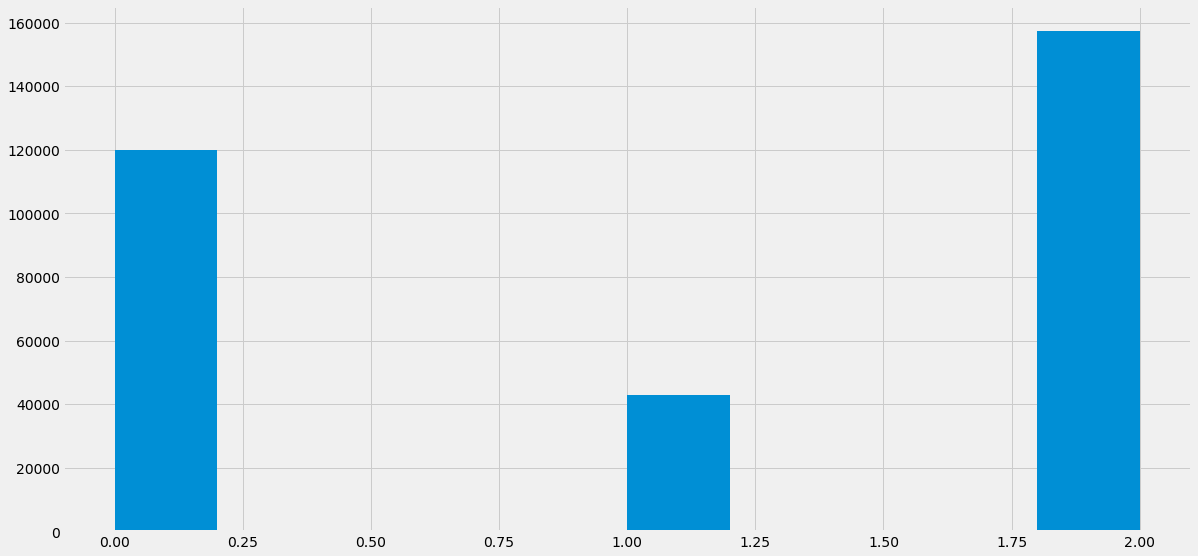

In [14]:
for i in trn1.columns:
    print(i)
    trn1[i].hist()
    plt.show()


In [15]:
tst = pd.read_csv(tst_file, index_col = 0)
tst

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z
id,,,,,,,,,,,,,,,,,,
320000,19.1431,18.0172,17.4733,17.1144,16.9263,1.2130e-01,19.0750,17.9550,17.4308,17.0838,16.9087,1,1,1.1563,1.1515,1.1613,1.1588,1.1539
320001,18.7409,17.1705,16.3691,15.9865,15.7307,-6.6907e-05,15.0703,14.3098,14.3901,14.5160,14.6372,2,2,1.0076,1.0074,1.0080,1.0078,1.0075
320002,19.2980,17.8803,17.2221,16.8096,16.6352,1.1001e-01,19.1004,17.7726,17.1460,16.7497,16.5689,1,1,1.3809,1.3905,1.3715,1.3761,1.3856
320003,18.0775,17.1569,16.9041,16.8118,16.7955,2.9697e-05,17.9729,17.0735,16.8470,16.7700,16.7668,1,1,1.1408,1.1408,1.1409,1.1408,1.1408
320004,17.8325,16.7646,16.2135,15.8722,15.6621,6.8471e-02,17.7545,16.6794,16.1563,15.8315,15.6433,2,2,1.1110,1.1077,1.1145,1.1127,1.1093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,19.6734,18.6617,18.2708,18.1225,18.0627,-3.1726e-04,19.3361,18.3933,18.0860,17.9861,17.9670,17,17,1.1858,1.1863,1.1855,1.1857,1.1861
399996,21.5229,20.7283,20.6087,21.0049,20.8458,6.5455e-02,21.3993,20.6399,20.5451,20.9507,20.7827,8,4,1.2850,1.2908,1.2793,1.2821,1.2878
399997,19.3991,18.2411,18.1605,18.1978,18.2018,-8.4180e-04,18.9136,17.8753,17.9047,18.0043,18.0400,1,1,1.1885,1.1886,1.1885,1.1885,1.1885


In [16]:
df = pd.concat([trn1, tst])
df

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
id,,,,,,,,,,,,,,,,,,,
0,23.2640,20.3368,19.0095,17.6724,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,18,18,1.1898,1.1907,1.1890,1.1894,1.1902,0.0
1,15.0521,14.0620,13.4524,13.2684,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1,1,1.2533,1.2578,1.2488,1.2510,1.2555,1.0
2,16.7864,15.8254,15.5363,15.3935,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,2,2,1.0225,1.0241,1.0210,1.0217,1.0233,0.0
3,25.6606,21.1887,20.2212,19.8949,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,4,3,1.2054,1.2061,1.2049,1.2051,1.2057,0.0
4,24.4534,20.6992,19.0424,18.3242,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,13,12,1.1939,1.1943,1.1937,1.1938,1.1941,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,19.6734,18.6617,18.2708,18.1225,18.0627,-3.1726e-04,19.3361,18.3933,18.0860,17.9861,17.9670,17,17,1.1858,1.1863,1.1855,1.1857,1.1861,NaN
399996,21.5229,20.7283,20.6087,21.0049,20.8458,6.5455e-02,21.3993,20.6399,20.5451,20.9507,20.7827,8,4,1.2850,1.2908,1.2793,1.2821,1.2878,NaN
399997,19.3991,18.2411,18.1605,18.1978,18.2018,-8.4180e-04,18.9136,17.8753,17.9047,18.0043,18.0400,1,1,1.1885,1.1886,1.1885,1.1885,1.1885,NaN


In [17]:
#dered - 한자리
df['d_dered_u'] = df['dered_u'] - df['u']
df['d_dered_g'] = df['dered_g'] - df['g']
df['d_dered_r'] = df['dered_r'] - df['r']
df['d_dered_i'] = df['dered_i'] - df['i']
df['d_dered_z'] = df['dered_z'] - df['z']
df['dered_ur'] = df['dered_u'] - df['r']
df['dered_gi'] = df['dered_g'] - df['i']
df['dered_gz'] = df['dered_g'] - df['z']
df['dered_ru'] = df['dered_r'] - df['u']
df['dered_ig'] = df['dered_i'] - df['g']
df['dered_iz'] = df['dered_i'] - df['z']
df['dered_zi'] = df['dered_z'] - df['i']

#dered - dered
df['d_dered_ur'] = df['dered_u'] - df['dered_r']
df['d_dered_rg'] = df['dered_r'] - df['dered_g']
df['d_dered_ig'] = df['dered_i'] - df['dered_g']
df['d_dered_zg'] = df['dered_z'] - df['dered_g']
df['d_dered_ri'] = df['dered_r'] - df['dered_i']
df['d_dered_rz'] = df['dered_r'] - df['dered_z']
df['d_dered_iz'] = df['dered_i'] - df['dered_z']
df['d_obs_det'] = df['nObserve'] - df['nDetect']

#airmass 끼리
df['air_ug'] = df['airmass_u'] - df['airmass_g']
df['air_ur'] = df['airmass_u'] - df['airmass_r']
df['air_ui'] = df['airmass_u'] - df['airmass_i']
df['air_uz'] = df['airmass_u'] - df['airmass_z']
df['air_gr'] = df['airmass_g'] - df['airmass_r']
df['air_gi'] = df['airmass_g'] - df['airmass_i']
df['air_gz'] = df['airmass_g'] - df['airmass_z']
df['air_ri'] = df['airmass_r'] - df['airmass_i']
df['air_rz'] = df['airmass_r'] - df['airmass_z']
df['air_iz'] = df['airmass_i'] - df['airmass_z']

#한자리 끼리
df['ur'] = df['u'] - df['r']
df['ug'] = df['u'] - df['g']
df['gi'] = df['g'] - df['i']
df['gz'] = df['g'] - df['z']
df['iz'] = df['i'] - df['z']

# 
df

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,dered_ur,dered_gi,dered_gz,dered_ru,dered_ig,dered_iz,dered_zi,d_dered_ur,d_dered_rg,d_dered_ig,d_dered_zg,d_dered_ri,d_dered_rz,d_dered_iz,d_obs_det,air_ug,air_ur,air_ui,air_uz,air_gr,air_gi,air_gz,air_ri,air_rz,air_iz,ur,ug,gi,gz,iz
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,23.2640,20.3368,19.0095,17.6724,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,18,18,1.1898,1.1907,1.1890,1.1894,1.1902,0.0,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,4.1148,2.5854,3.3182,-4.3088,-2.7047,0.6925,-0.7635,4.1691,-1.3027,-2.6257,-3.3488,1.3230,2.0462,0.7232,0,-9.1700e-04,7.8500e-04,4.0900e-04,-4.4200e-04,1.7020e-03,1.3260e-03,4.7500e-04,-3.7600e-04,-1.2270e-03,-8.5100e-04,4.2545,2.9272,2.6643,3.3972,0.7328
1,15.0521,14.0620,13.4524,13.2684,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1,1,1.2533,1.2578,1.2488,1.2510,1.2555,1.0,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,1.5140,0.7361,0.8356,-1.6408,-0.8257,0.0673,-0.1338,1.5550,-0.5931,-0.7683,-0.8698,0.1751,0.2767,0.1016,0,-4.5820e-03,4.4920e-03,2.2570e-03,-2.2790e-03,9.0740e-03,6.8390e-03,2.3030e-03,-2.2350e-03,-6.7710e-03,-4.5360e-03,1.5997,0.9902,0.7935,0.8930,0.0995
2,16.7864,15.8254,15.5363,15.3935,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,2,2,1.0225,1.0241,1.0210,1.0217,1.0233,0.0,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,1.0713,0.2931,0.3366,-1.3463,-0.5037,-0.0283,-0.0975,1.1676,-0.2466,-0.3649,-0.3905,0.1183,0.1440,0.0257,0,-1.6060e-03,1.5160e-03,7.6900e-04,-7.9200e-04,3.1220e-03,2.3750e-03,8.1400e-04,-7.4700e-04,-2.3080e-03,-1.5610e-03,1.2501,0.9610,0.4319,0.4754,0.0435
3,25.6606,21.1887,20.2212,19.8949,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,4,3,1.2054,1.2061,1.2049,1.2051,1.2057,0.0,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,5.1325,1.0997,1.3600,-5.5734,-1.3941,0.1600,-0.3398,5.2664,-0.9074,-1.2000,-1.4395,0.2926,0.5321,0.2395,1,-6.5900e-04,5.2500e-04,2.7900e-04,-3.1300e-04,1.1840e-03,9.3800e-04,3.4600e-04,-2.4600e-04,-8.3800e-04,-5.9200e-04,5.4395,4.4719,1.2938,1.5541,0.2603
4,24.4534,20.6992,19.0424,18.3242,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,13,12,1.1939,1.1943,1.1937,1.1938,1.1941,0.0,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,4.7290,2.1097,2.4512,-5.5904,-2.5089,0.2076,-0.4482,4.9084,-1.5709,-2.2436,-2.5579,0.6727,0.9871,0.3144,1,-3.3900e-04,2.0800e-04,1.2000e-04,-1.5300e-04,5.4700e-04,4.5900e-04,1.8600e-04,-8.8000e-05,-3.6100e-04,-2.7300e-04,5.4111,3.7543,2.3750,2.7165,0.3415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,19.6734,18.6617,18.2708,18.1225,18.0627,-3.1726e-04,19.3361,18.3933,18.0860,17.9861,17.9670,17,17,1.1858,1.1863,1.1855,1.1857,1.1861,NaN,-0.3372,-0.2684,-0.1848,-0.1364,-0.0957,1.0654,0.2708,0.3306,-1.5874,-0.6756,-0.0766,-0.1555,1.2501,-0.3073,-0.4072,-0.4263,0.0999,0.1190,0.0191,0,-4.7900e-04,3.5000e-04,1.9100e-04,-2.2400e-04,8.2900e-04,6.7000e-04,2.5500e-04,-1.5900e-04,-5.7400e-04,-4.1500e-04,1.4026,1.0117,0.5392,0.5990,0.0598
399996,21.5229,20.7283,20.6087,21.0049,20.8458,6.5455e-02,21.3993,20.6399,20.5451,20.9507,20.7827,8,4,1.2850,1.2908,1.2793,1.2821,1.2878,NaN,-0.1235,-0.0884,-0.0636,-0.0542,-0.0631,0.7907,-0.3650,-0.2059,-0.9778,0.2224,0.1049,-0.2222,0.8543,-0.0949,0.3108,0.1428,-0.4056,-0.2376,0.1680,4,-5.8160e-03,5.6270e-03,2.8360e-03,-2.8820e-03,1.1443e-02,8.6520e-03,2.9340e-03,-2.7910e-03,-8.5090e-03,-5.7180e-03,0.9142,0.7946,-0.2766,-0.1175,0.1591
399997,19.3991,18.2411,18.1605,18.1978,18.2018,-8.4180e-04,18.9136,17.8753,17.9047,18.0043,18.0400,1,1,1.1885,1.1886,1.1885,1.1885,1.1885,NaN,-0.4855,-0.3657,-0.2558,-0.1935,-0.1618,0.7531,-0.3224,-0.3265,-1.4944,-0.2368,-0.1976,-0.1578,1.0089,0.0294,0.1289

In [18]:
# 첨도부분 처리
df['airmass_g'] = np.sqrt(np.log(df['airmass_g']))
df['airmass_i'] = np.sqrt(np.log(df['airmass_i']))
df['airmass_r'] = np.sqrt(np.log(df['airmass_r']))
#Train_copy1['airmass_r'] = np.log(Train_copy1['airmass_r'])
#Train_copy1['airmass_u'] = np.log1p(np.log1p(Train_copy1['airmass_u']))
#Train_copy1['airmass_z'] = np.log1p(np.log1p(Train_copy1['airmass_z']))
df['airmass_u'] = np.sqrt(np.log(df['airmass_u']))
df['airmass_z'] = np.sqrt(np.log(df['airmass_z']))

#Train_copy1['nDetect'] = np.log(Train_copy1['nDetect'])
df['nDetect'] = np.log(df['nDetect'])
#Train_copy1['nObserve'] = np.log1p(Train_copy1['nObserve']) #sqrt ,cbrt
df['nObserve'] = np.log(df['nObserve'])

df['r'] = np.log(df['r'])
df['u'] = np.log(df['u'])
df['g'] = np.log(df['g'])
df['i'] = np.log(df['i'])
df['z'] = np.log(df['z'])

df['dered_r'] = np.sqrt(np.log(df['dered_r']))
df['dered_i'] = np.sqrt(np.log(df['dered_i']))
df['dered_u'] = np.sqrt(np.log(df['dered_u']))
df['dered_g'] = np.sqrt(np.log(df['dered_g']))
df['dered_z'] = np.sqrt(np.log(df['dered_z']))


In [19]:
Y = df['class']
X = df.drop(['class'], axis = 1)
X

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,dered_ur,dered_gi,dered_gz,dered_ru,dered_ig,dered_iz,dered_zi,d_dered_ur,d_dered_rg,d_dered_ig,d_dered_zg,d_dered_ri,d_dered_rz,d_dered_iz,d_obs_det,air_ug,air_ur,air_ui,air_uz,air_gr,air_gi,air_gz,air_ri,air_rz,air_iz,ur,ug,gi,gz,iz
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3.1469,3.0124,2.9449,2.8720,2.8297,-8.1086e-05,1.7723,1.7345,1.7152,1.6940,1.6816,2.8904,2.8904,0.4168,0.4178,0.4160,0.4164,0.4173,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,4.1148,2.5854,3.3182,-4.3088,-2.7047,0.6925,-0.7635,4.1691,-1.3027,-2.6257,-3.3488,1.3230,2.0462,0.7232,0,-9.1700e-04,7.8500e-04,4.0900e-04,-4.4200e-04,1.7020e-03,1.3260e-03,4.7500e-04,-3.7600e-04,-1.2270e-03,-8.5100e-04,4.2545,2.9272,2.6643,3.3972,0.7328
1,2.7115,2.6435,2.5992,2.5854,2.5779,4.5061e-03,1.6449,1.6246,1.6112,1.6072,1.6048,0.0000,0.0000,0.4751,0.4789,0.4713,0.4732,0.4770,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,1.5140,0.7361,0.8356,-1.6408,-0.8257,0.0673,-0.1338,1.5550,-0.5931,-0.7683,-0.8698,0.1751,0.2767,0.1016,0,-4.5820e-03,4.4920e-03,2.2570e-03,-2.2790e-03,9.0740e-03,6.8390e-03,2.3030e-03,-2.2350e-03,-6.7710e-03,-4.5360e-03,1.5997,0.9902,0.7935,0.8930,0.0995
2,2.8206,2.7616,2.7432,2.7339,2.7311,4.7198e-04,1.6763,1.6592,1.6544,1.6521,1.6515,0.6931,0.6931,0.1492,0.1543,0.1441,0.1466,0.1517,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,1.0713,0.2931,0.3366,-1.3463,-0.5037,-0.0283,-0.0975,1.1676,-0.2466,-0.3649,-0.3905,0.1183,0.1440,0.0257,0,-1.6060e-03,1.5160e-03,7.6900e-04,-7.9200e-04,3.1220e-03,2.3750e-03,8.1400e-04,-7.4700e-04,-2.3080e-03,-1.5610e-03,1.2501,0.9610,0.4319,0.4754,0.0435
3,3.2450,3.0535,3.0067,2.9905,2.9773,5.8143e-06,1.7980,1.7448,1.7321,1.7278,1.7243,1.3863,1.0986,0.4322,0.4328,0.4317,0.4319,0.4325,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,5.1325,1.0997,1.3600,-5.5734,-1.3941,0.1600,-0.3398,5.2664,-0.9074,-1.2000,-1.4395,0.2926,0.5321,0.2395,1,-6.5900e-04,5.2500e-04,2.7900e-04,-3.1300e-04,1.1840e-03,9.3800e-04,3.4600e-04,-2.4600e-04,-8.3800e-04,-5.9200e-04,5.4395,4.4719,1.2938,1.5541,0.2603
4,3.1968,3.0301,2.9467,2.9082,2.8894,-3.3247e-05,1.7800,1.7370,1.7138,1.7032,1.6981,2.5649,2.4849,0.4210,0.4214,0.4208,0.4209,0.4212,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,4.7290,2.1097,2.4512,-5.5904,-2.5089,0.2076,-0.4482,4.9084,-1.5709,-2.2436,-2.5579,0.6727,0.9871,0.3144,1,-3.3900e-04,2.0800e-04,1.2000e-04,-1.5300e-04,5.4700e-04,4.5900e-04,1.8600e-04,-8.8000e-05,-3.6100e-04,-2.7300e-04,5.4111,3.7543,2.3750,2.7165,0.3415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,2.9793,2.9265,2.9053,2.8972,2.8938,-3.1726e-04,1.7210,1.7065,1.7015,1.6999,1.6996,2.8332,2.8332,0.4129,0.4133,0.4125,0.4127,0.4131,-0.3372,-0.2684,-0.1848,-0.1364,-0.0957,1.0654,0.2708,0.3306,-1.5874,-0.6756,-0.0766,-0.1555,1.2501,-0.3073,-0.4072,-0.4263,0.0999,0.1190,0.0191,0,-4.7900e-04,3.5000e-04,1.9100e-04,-2.2400e-04,8.2900e-04,6.7000e-04,2.5500e-04,-1.5900e-04,-5.7400e-04,-4.1500e-04,1.4026,1.0117,0.5392,0.5990,0.0598
399996,3.0691,3.0315,3.0257,3.0448,3.0372,6.5455e-02,1.7502,1.7399,1.7386,1.7442,1.7419,2.0794,1.3863,0.5007,0.5052,0.4963,0.4985,0.5030,-0.1235,-0.0884,-0.0636,-0.0542,-0.0631,0.7907,-0.3650,-0.2059,-0.9778,0.2224,0.1049,-0.2222,0.8543,-0.0949,0.3108,0.1428,-0.4056,-0.2376,0.1680,4,-5.8160e-03,5.6270e-03,2.8360e-03,-2.8820e-03,1.1443e-02,8.6520e-03,2.9340e-03,-2.7910e-03,-8.5090e-03,-5.7180e-03,0.9142,0.7946,-0.2766,-0.1175,0.1591
399997,2.9652,2.9037,2.8992,2.9013,2.9015,-8.4180e-04,1.7146,1.6981,1.6985,1.7002,1.7008,0.0000,0.0000,0.4155,0.4156,0.4156,0.4155,0.4156,-0.4855,-0.3657,-0.2558,-0.1935,-0.1618,0.7531,-0.3224,-0.3265,-1.4944,-0.2368,-0.1976,-0.1578,1.0089,0.0294,0.1289,0.1647,-0.0996,-0.1353,-0.0357,0,-8.8000e-05,-4.

# 표준화 및 정규화 , 이상치제거

In [20]:
# 표준화 : RobustScaler() :
# 이상치, 특이값에 덜 민감한" 중앙값(median)과 IQR(Inter-Quartile Range)을 이용해서 척도를 표준화하는 방법
#  (x-median)/IQR )

x_RobustScaler = RobustScaler().fit_transform(X)
X = pd.DataFrame(x_RobustScaler, columns = X.columns)
X
#len(x_RobustScaler)

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,dered_ur,dered_gi,dered_gz,dered_ru,dered_ig,dered_iz,dered_zi,d_dered_ur,d_dered_rg,d_dered_ig,d_dered_zg,d_dered_ri,d_dered_rz,d_dered_iz,d_obs_det,air_ug,air_ur,air_ui,air_uz,air_gr,air_gi,air_gz,air_ri,air_rz,air_iz,ur,ug,gi,gz,iz
0,2.0687,1.3048,0.9240,0.3484,0.0148,-0.4991,2.1350,1.3611,0.9617,0.3694,0.0274,1.3652,1.3652,0.0659,0.0731,0.0600,0.0627,0.0693,-0.0335,0.2211,0.2266,0.2292,0.2011,2.5110,2.7096,2.6890,-2.3742,-2.5860,2.3548,-2.3455,2.4944,-1.6750,-2.7048,-2.6852,4.6283,3.7105,2.4621,0.0,-0.0470,0.0378,0.0399,-0.0455,0.0425,0.0455,0.0479,-0.0357,-0.0401,-0.0425,2.4891,3.1369,2.6824,2.6758,2.4639
1,-2.9196,-2.9094,-3.0101,-2.9859,-2.9560,-0.4506,-3.0643,-3.0343,-3.1401,-3.0904,-3.0508,-0.4307,-0.4307,0.4254,0.4547,0.3965,0.4104,0.4398,0.2966,0.4329,0.4182,0.3851,0.1280,-0.2233,-0.1785,-0.2777,0.3672,0.3528,-0.3806,0.6243,-0.2781,-0.0256,0.2351,0.2986,-0.7644,-0.6322,-0.4697,0.0,-0.7558,0.7569,0.7565,-0.7567,0.7566,0.7569,0.7543,-0.7574,-0.7566,-0.7565,-0.3234,-0.5391,-0.3039,-0.3776,-0.5767
2,-1.6702,-1.5600,-1.3715,-1.2577,-1.1478,-0.4932,-1.7849,-1.6528,-1.4390,-1.3024,-1.1771,0.0000,0.0000,-1.5852,-1.5699,-1.5949,-1.5890,-1.5773,-0.2723,-0.3676,-0.3745,-0.3742,-0.2724,-0.6887,-0.8704,-0.8741,0.6697,0.8565,-0.7989,0.7955,-0.6890,0.7800,0.8737,0.8755,-1.0314,-0.9580,-0.8278,0.0,-0.1802,0.1796,0.1795,-0.1810,0.1800,0.1809,0.1789,-0.1798,-0.1798,-0.1801,-0.6938,-0.5946,-0.8811,-0.8868,-0.8456
3,3.1921,1.7735,1.6270,1.7265,1.7567,-0.4982,3.1877,1.7718,1.6253,1.7160,1.7371,0.4307,0.2519,0.1607,0.1672,0.1554,0.1577,0.1637,-1.0566,-0.9110,-0.9140,-0.9205,-0.7914,3.5810,0.3894,0.3489,-3.6734,-0.5361,0.0250,-0.3472,3.6581,-0.7561,-0.4482,-0.3870,-0.2125,-0.0054,0.1807,1.0,0.0029,-0.0126,-0.0105,0.0045,-0.0077,-0.0045,-0.0019,0.0148,0.0102,0.0077,3.7445,6.0684,0.4947,0.4284,0.1953
4,2.6400,1.5065,0.9436,0.7697,0.7198,-0.4986,2.4523,1.4608,0.9056,0.7348,0.6864,1.1630,1.1133,0.0917,0.0956,0.0891,0.0901,0.0934,-3.3503,-1.6119,-1.5666,-1.5642,-1.3457,3.1568,1.9667,1.6529,-3.6910,-2.2798,0.2334,-0.8587,3.2784,-2.2984,-2.1000,-1.7332,1.5732,1.1112,0.5339,1.0,0.0648,-0.0741,-0.0721,0.0664,-0.0694,-0.0663,-0.0638,0.0761,0.0719,0.0695,3.7144,4.7065,2.2206,1.8458,0.5852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399973,0.1480,0.3230,0.4730,0.6410,0.7722,-0.5016,0.0436,0.2388,0.4199,0.6027,0.7463,1.3297,1.3297,0.0414,0.0456,0.0385,0.0397,0.0433,-1.2417,-1.6416,-1.6442,-1.6127,-1.1211,-0.6950,-0.9051,-0.8812,0.4220,0.5877,-1.0101,0.5217,-0.6015,0.6388,0.8066,0.8324,-1.1179,-1.0192,-0.8586,0.0,0.0377,-0.0466,-0.0446,0.0389,-0.0421,-0.0391,-0.0371,0.0485,0.0443,0.0419,-0.5322,-0.4982,-0.7099,-0.7361,-0.7672
399974,1.1774,1.5226,1.8430,2.3581,2.4629,0.1937,1.2363,1.5762,1.8814,2.3671,2.4405,0.8614,0.4307,0.5833,0.6186,0.5486,0.5652,0.6005,0.0654,0.1288,0.0938,-0.0364,-0.4589,-0.9838,-1.8980,-1.5223,1.0483,1.9922,-0.2162,0.2072,-1.0213,1.1326,1.9431,1.5174,-3.4929,-1.8945,-0.1564,4.0,-0.9944,0.9771,0.9810,-0.9901,0.9861,0.9908,0.9981,-0.9733,-0.9813,-0.9856,-1.0496,-0.9103,-2.0120,-1.6098,-0.2907
399975,-0.0129,0.0626,0.4041,0.6892,0.8627,-0.5071,-0.2191,-0.0967,0.3030,0.6145,0.7941,-0.4307,-0.4307,0.0579,0.0598,0.0572,0.0573,0.0586,-2.1482,-2.5996,-2.6630,-2.7072,-2.4664,-1.0232,-1.8316,-1.6664,0.5176,1.2739,-1.5395,0.5112,-0.8574,1.4214,1.6553,1.5438,-2.0550,-1.6434,-1.1173,0.0,0.1133,-0.1228,-0.1206,0.1148,-0.1180,-0.1148,-0.1124,0.1250,0.1205,0.1179,-0.7060,-0.2207,-1.5014,-1.4186,-1.0740
399976,-0.3116,-0.3455,-0.2586,-0.2251,-0.2280,-0.0456,-0.3089,-0.3552,-0.2634,-0.2254,-0.2225,1.3297,1.3297,0.0069,0.0136,0.0018,0.0041,0.0101,0.0367,-0.1124,-0.1009,-0.0788,0.0914,-0.0922,-0.2885,-0.208

In [21]:
# 정규화
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
X

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,dered_ur,dered_gi,dered_gz,dered_ru,dered_ig,dered_iz,dered_zi,d_dered_ur,d_dered_rg,d_dered_ig,d_dered_zg,d_dered_ri,d_dered_rz,d_dered_iz,d_obs_det,air_ug,air_ur,air_ui,air_uz,air_gr,air_gi,air_gz,air_ri,air_rz,air_iz,ur,ug,gi,gz,iz
0,0.7159,0.6458,0.4032,0.6407,0.2313,0.7271,0.9447,0.8507,0.7193,0.8117,0.7143,0.7638,0.7733,0.4872,0.4860,0.4882,0.4876,0.4868,0.6797,0.4761,0.6079,0.5411,0.9963,0.7167,0.7192,0.9913,0.6176,0.5433,0.9928,0.9982,0.6788,0.4645,0.4133,0.9978,0.5107,0.0020,0.0017,0.0244,0.7078,0.2994,0.2968,0.7055,0.2955,0.2937,0.2899,0.6980,0.7026,0.7044,0.6035,0.5104,0.4568,0.9970,0.9928
1,0.5821,0.5607,0.2482,0.5420,0.1991,0.7271,0.8567,0.7119,0.5193,0.7143,0.5849,0.0000,0.0000,0.5566,0.5578,0.5550,0.5558,0.5574,0.6804,0.4762,0.6081,0.5413,0.9963,0.6853,0.6854,0.9909,0.6599,0.5564,0.9927,0.9982,0.6107,0.4880,0.4752,0.9980,0.4713,0.0018,0.0017,0.0244,0.6171,0.3926,0.3894,0.6141,0.3875,0.3850,0.3799,0.6041,0.6100,0.6124,0.5765,0.4954,0.4438,0.9966,0.9927
2,0.6156,0.5880,0.3127,0.5932,0.2187,0.7271,0.8783,0.7555,0.6023,0.7646,0.6637,0.1832,0.1854,0.1685,0.1770,0.1592,0.1637,0.1731,0.6792,0.4757,0.6074,0.5405,0.9963,0.6800,0.6773,0.9909,0.6646,0.5587,0.9927,0.9982,0.6006,0.4995,0.4887,0.9981,0.4693,0.0018,0.0017,0.0244,0.6908,0.3178,0.3148,0.6881,0.3132,0.3111,0.3066,0.6792,0.6846,0.6867,0.5730,0.4951,0.4413,0.9966,0.9927
3,0.7461,0.6553,0.4308,0.6815,0.2501,0.7271,0.9626,0.8637,0.7516,0.8497,0.7863,0.3663,0.2939,0.5055,0.5037,0.5071,0.5062,0.5048,0.6776,0.4753,0.6069,0.5399,0.9963,0.7290,0.6921,0.9910,0.5976,0.5525,0.9927,0.9982,0.7074,0.4776,0.4609,0.9980,0.4753,0.0018,0.0017,0.0488,0.7142,0.2929,0.2903,0.7120,0.2890,0.2873,0.2836,0.7045,0.7091,0.7109,0.6156,0.5223,0.4473,0.9967,0.9928
4,0.7313,0.6499,0.4039,0.6532,0.2389,0.7271,0.9501,0.8539,0.7165,0.8220,0.7421,0.6778,0.6648,0.4922,0.4903,0.4939,0.4930,0.4914,0.6729,0.4748,0.6063,0.5392,0.9963,0.7241,0.7105,0.9912,0.5973,0.5447,0.9928,0.9982,0.6981,0.4556,0.4261,0.9979,0.4884,0.0019,0.0017,0.0488,0.7221,0.2849,0.2823,0.7199,0.2810,0.2793,0.2757,0.7125,0.7171,0.7188,0.6153,0.5168,0.4548,0.9969,0.9928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399973,0.6644,0.6260,0.3854,0.6494,0.2395,0.7271,0.9093,0.8153,0.6929,0.8183,0.7446,0.7487,0.7580,0.4825,0.4809,0.4839,0.4831,0.4819,0.6772,0.4748,0.6062,0.5391,0.9963,0.6799,0.6769,0.9909,0.6607,0.5575,0.9927,0.9982,0.6027,0.4975,0.4873,0.9981,0.4687,0.0018,0.0017,0.0244,0.7187,0.2885,0.2859,0.7164,0.2846,0.2828,0.2791,0.7089,0.7136,0.7153,0.5745,0.4955,0.4420,0.9966,0.9927
399974,0.6920,0.6502,0.4394,0.7002,0.2577,0.7274,0.9295,0.8575,0.7641,0.8680,0.8158,0.5495,0.3709,0.5871,0.5886,0.5853,0.5861,0.5880,0.6799,0.4760,0.6078,0.5409,0.9963,0.6766,0.6653,0.9908,0.6704,0.5638,0.9927,0.9982,0.5924,0.5045,0.5112,0.9981,0.4514,0.0017,0.0017,0.1220,0.5865,0.4212,0.4184,0.5841,0.4170,0.4151,0.4110,0.5760,0.5809,0.5829,0.5695,0.4938,0.4363,0.9965,0.9927
399975,0.6601,0.6207,0.3827,0.6508,0.2404,0.7271,0.9049,0.8047,0.6872,0.8186,0.7466,0.0000,0.0000,0.4857,0.4835,0.4876,0.4865,0.4848,0.6754,0.4741,0.6053,0.5379,0.9963,0.6762,0.6661,0.9908,0.6622,0.5606,0.9927,0.9982,0.5964,0.5087,0.5051,0.9981,0.4619,0.0018,0.0017,0.0244,0.7283,0.2786,0.2760,0.7262,0.2748,0.2731,0.2695,0.7189,0.7234,0.7251,0.5728,0.4967,0.4385,0.9965,0.9927
399976,0.6521,0.6125,0.3566,0.6238,0.2286,0.7273,0.9033,0.7965,0.6596,0.7950,0.7038,0.7487,0.7580,0.4758,0.4748,0.4766,0.4761,0.4756,0.6798,0.4759,0.6076,0.5408,0.9963,0.6869,0.6841,0.9910,0.6567,0.5564,0.9928,0.9982,0.6149,0.4933,0.4768,0.9980,0.4752,0.0018,0.0017,0.0244,0.7082,0.2991,0.2965,0.7060,0.2951,0.2933,0.2895,0.6982,0.7030,0.7048,0.5782,0.4977,0.4437,0.9967,0.

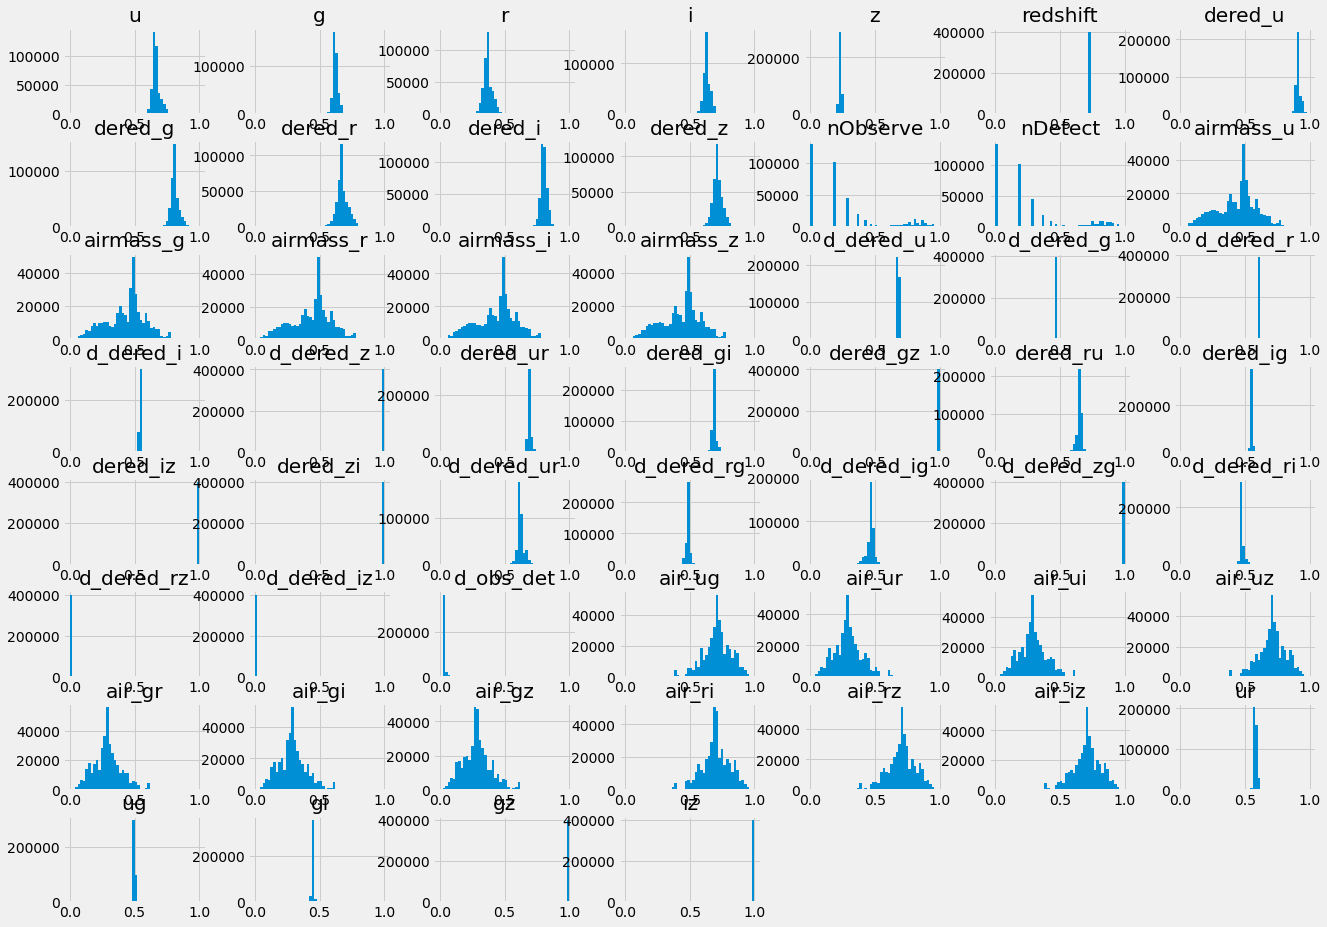

In [22]:
X.hist(bins = 50,  figsize=(20,15))
plt.show()

In [23]:
df1 = X 
df1['class']= list(Y)
df1

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,dered_ur,dered_gi,dered_gz,dered_ru,dered_ig,dered_iz,dered_zi,d_dered_ur,d_dered_rg,d_dered_ig,d_dered_zg,d_dered_ri,d_dered_rz,d_dered_iz,d_obs_det,air_ug,air_ur,air_ui,air_uz,air_gr,air_gi,air_gz,air_ri,air_rz,air_iz,ur,ug,gi,gz,iz,class
0,0.7159,0.6458,0.4032,0.6407,0.2313,0.7271,0.9447,0.8507,0.7193,0.8117,0.7143,0.7638,0.7733,0.4872,0.4860,0.4882,0.4876,0.4868,0.6797,0.4761,0.6079,0.5411,0.9963,0.7167,0.7192,0.9913,0.6176,0.5433,0.9928,0.9982,0.6788,0.4645,0.4133,0.9978,0.5107,0.0020,0.0017,0.0244,0.7078,0.2994,0.2968,0.7055,0.2955,0.2937,0.2899,0.6980,0.7026,0.7044,0.6035,0.5104,0.4568,0.9970,0.9928,0.0
1,0.5821,0.5607,0.2482,0.5420,0.1991,0.7271,0.8567,0.7119,0.5193,0.7143,0.5849,0.0000,0.0000,0.5566,0.5578,0.5550,0.5558,0.5574,0.6804,0.4762,0.6081,0.5413,0.9963,0.6853,0.6854,0.9909,0.6599,0.5564,0.9927,0.9982,0.6107,0.4880,0.4752,0.9980,0.4713,0.0018,0.0017,0.0244,0.6171,0.3926,0.3894,0.6141,0.3875,0.3850,0.3799,0.6041,0.6100,0.6124,0.5765,0.4954,0.4438,0.9966,0.9927,1.0
2,0.6156,0.5880,0.3127,0.5932,0.2187,0.7271,0.8783,0.7555,0.6023,0.7646,0.6637,0.1832,0.1854,0.1685,0.1770,0.1592,0.1637,0.1731,0.6792,0.4757,0.6074,0.5405,0.9963,0.6800,0.6773,0.9909,0.6646,0.5587,0.9927,0.9982,0.6006,0.4995,0.4887,0.9981,0.4693,0.0018,0.0017,0.0244,0.6908,0.3178,0.3148,0.6881,0.3132,0.3111,0.3066,0.6792,0.6846,0.6867,0.5730,0.4951,0.4413,0.9966,0.9927,0.0
3,0.7461,0.6553,0.4308,0.6815,0.2501,0.7271,0.9626,0.8637,0.7516,0.8497,0.7863,0.3663,0.2939,0.5055,0.5037,0.5071,0.5062,0.5048,0.6776,0.4753,0.6069,0.5399,0.9963,0.7290,0.6921,0.9910,0.5976,0.5525,0.9927,0.9982,0.7074,0.4776,0.4609,0.9980,0.4753,0.0018,0.0017,0.0488,0.7142,0.2929,0.2903,0.7120,0.2890,0.2873,0.2836,0.7045,0.7091,0.7109,0.6156,0.5223,0.4473,0.9967,0.9928,0.0
4,0.7313,0.6499,0.4039,0.6532,0.2389,0.7271,0.9501,0.8539,0.7165,0.8220,0.7421,0.6778,0.6648,0.4922,0.4903,0.4939,0.4930,0.4914,0.6729,0.4748,0.6063,0.5392,0.9963,0.7241,0.7105,0.9912,0.5973,0.5447,0.9928,0.9982,0.6981,0.4556,0.4261,0.9979,0.4884,0.0019,0.0017,0.0488,0.7221,0.2849,0.2823,0.7199,0.2810,0.2793,0.2757,0.7125,0.7171,0.7188,0.6153,0.5168,0.4548,0.9969,0.9928,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399973,0.6644,0.6260,0.3854,0.6494,0.2395,0.7271,0.9093,0.8153,0.6929,0.8183,0.7446,0.7487,0.7580,0.4825,0.4809,0.4839,0.4831,0.4819,0.6772,0.4748,0.6062,0.5391,0.9963,0.6799,0.6769,0.9909,0.6607,0.5575,0.9927,0.9982,0.6027,0.4975,0.4873,0.9981,0.4687,0.0018,0.0017,0.0244,0.7187,0.2885,0.2859,0.7164,0.2846,0.2828,0.2791,0.7089,0.7136,0.7153,0.5745,0.4955,0.4420,0.9966,0.9927,NaN
399974,0.6920,0.6502,0.4394,0.7002,0.2577,0.7274,0.9295,0.8575,0.7641,0.8680,0.8158,0.5495,0.3709,0.5871,0.5886,0.5853,0.5861,0.5880,0.6799,0.4760,0.6078,0.5409,0.9963,0.6766,0.6653,0.9908,0.6704,0.5638,0.9927,0.9982,0.5924,0.5045,0.5112,0.9981,0.4514,0.0017,0.0017,0.1220,0.5865,0.4212,0.4184,0.5841,0.4170,0.4151,0.4110,0.5760,0.5809,0.5829,0.5695,0.4938,0.4363,0.9965,0.9927,NaN
399975,0.6601,0.6207,0.3827,0.6508,0.2404,0.7271,0.9049,0.8047,0.6872,0.8186,0.7466,0.0000,0.0000,0.4857,0.4835,0.4876,0.4865,0.4848,0.6754,0.4741,0.6053,0.5379,0.9963,0.6762,0.6661,0.9908,0.6622,0.5606,0.9927,0.9982,0.5964,0.5087,0.5051,0.9981,0.4619,0.0018,0.0017,0.0244,0.7283,0.2786,0.2760,0.7262,0.2748,0.2731,0.2695,0.7189,0.7234,0.7251,0.5728,0.4967,0.4385,0.9965,0.9927,NaN
399976,0.6521,0.6125,0.3566,0.6238,0.2286,0.7273,0.9033,0.7965,0.6596,0.7950,0.7038,0.7487,0.7580,0.4758,0.4748,0.4766,0.4761,0.4756,0.6798,0.4759,0.6076,0.5408,0.9963,0.6869,0.6841,0.9910,0.6567,0.5564,0.9928,0.9982,0.6149,0.4933,0.4768,0.9980,0.4752,0.0018,0.0017,0.0244,0.7082,0.2991,0.2965,0.7060,0.2951,0.2933,0.2895,0.6982,0.

# 훈련셋과 테스트셋 나누기

In [24]:
trn2 = df1.iloc[:319978]
tst2 = df1.iloc[319978:]
tst2.drop('class', axis =1 , inplace = True)
trn2.shape, tst2.shape

((319978, 54), (80000, 53))

# outlier

In [25]:
# 전체 데이터가 아닌 각 클래스별(0,1,2)로 이상치 처리
# Train_copy1 = Train_set.copy()

def remove_outlier(data, column):
    
    print(column)
    # 클래스 0처리
    column_data_0 = data[data['class']==0][column]
    quan_25_0 = np.percentile(column_data_0.values, 0.1) # 1분위수
    quan_75_0 = np.percentile(column_data_0.values, 99.9) # 3분위수
    iqr_0 = quan_75_0 - quan_25_0 # IQR 계산
    iqr_0 *= 1.5
    lowest_0 = quan_25_0 - iqr_0 # 최솟값 설정
    highest_0 = quan_75_0 + iqr_0 # 최댓값 설정
    outlier_index_0 = column_data_0[(column_data_0 < lowest_0) | (column_data_0 > highest_0)].index # 최솟값 ~ 최댓값 사이의 값만 출력
    print(len(outlier_index_0))
    
    # 클래스 1처리
    column_data_1 = data[data['class']==1][column]
    quan_25_1 = np.percentile(column_data_1.values, 0.1) # 1분위수
    quan_75_1 = np.percentile(column_data_1.values, 99.9) # 3분위수
    iqr_1 = quan_75_1 - quan_25_1 # IQR 계산
    iqr_1 *= 1.5
    lowest_1 = quan_25_1 - iqr_1 # 최솟값 설정
    highest_1 = quan_75_1 + iqr_1 # 최댓값 설정
    outlier_index_1 = column_data_1[(column_data_1 < lowest_1 )| (column_data_1 > highest_1)].index # 최솟값 ~ 최댓값 사이의 값만 출력
    print(len(outlier_index_1))
    
    # 클래스 2 처리
    column_data_2 = data[data['class']==2][column]
    quan_25_2 = np.percentile(column_data_2.values, 0.1) # 1분위수
    quan_75_2 = np.percentile(column_data_2.values, 99.9) # 3분위수
    iqr_2 = quan_75_2 - quan_25_2 # IQR 계산
    iqr_2 *= 1.5
    lowest_2 = quan_25_2 - iqr_2 # 최솟값 설정
    highest_2 = quan_75_2 + iqr_2 # 최댓값 설정
    outlier_index_2 = column_data_2[(column_data_2 < lowest_2 )| (column_data_2 > highest_2)].index # 최솟값 ~ 최댓값 사이의 값만 출력
    print(len(outlier_index_2))
    # outlier 행 제거
    data.drop(list(set(list(outlier_index_0) + list(outlier_index_1) + list(outlier_index_2))), axis = 0, inplace = True)
    print(data.shape)
    return data

In [26]:
col = list(trn2.columns)
col.remove('redshift')
col.remove('class')
col

['u',
 'g',
 'r',
 'i',
 'z',
 'dered_u',
 'dered_g',
 'dered_r',
 'dered_i',
 'dered_z',
 'nObserve',
 'nDetect',
 'airmass_u',
 'airmass_g',
 'airmass_r',
 'airmass_i',
 'airmass_z',
 'd_dered_u',
 'd_dered_g',
 'd_dered_r',
 'd_dered_i',
 'd_dered_z',
 'dered_ur',
 'dered_gi',
 'dered_gz',
 'dered_ru',
 'dered_ig',
 'dered_iz',
 'dered_zi',
 'd_dered_ur',
 'd_dered_rg',
 'd_dered_ig',
 'd_dered_zg',
 'd_dered_ri',
 'd_dered_rz',
 'd_dered_iz',
 'd_obs_det',
 'air_ug',
 'air_ur',
 'air_ui',
 'air_uz',
 'air_gr',
 'air_gi',
 'air_gz',
 'air_ri',
 'air_rz',
 'air_iz',
 'ur',
 'ug',
 'gi',
 'gz',
 'iz']

In [27]:
df2 = trn2.copy()
for i in col:
    
    ROT = remove_outlier(df2, i)
    
    df2 = ROT

df2

u
2
0
2
(319974, 54)
g
1
0
0
(319973, 54)
r
0
0
1
(319972, 54)
i
1
0
0
(319971, 54)
z
0
0
0
(319971, 54)
dered_u
0
0
0
(319971, 54)
dered_g
2
0
0
(319969, 54)
dered_r
0
0
0
(319969, 54)
dered_i
0
0
0
(319969, 54)
dered_z
0
0
0
(319969, 54)
nObserve
0
0
0
(319969, 54)
nDetect
0
0
0
(319969, 54)
airmass_u
0
0
0
(319969, 54)
airmass_g
0
0
0
(319969, 54)
airmass_r
0
0
0
(319969, 54)
airmass_i
0
0
0
(319969, 54)
airmass_z
0
0
0
(319969, 54)
d_dered_u
3
9
22
(319935, 54)
d_dered_g
2
18
61
(319854, 54)
d_dered_r
4
19
48
(319783, 54)
d_dered_i
13
14
60
(319696, 54)
d_dered_z
20
16
48
(319612, 54)
dered_ur
0
0
1
(319611, 54)
dered_gi
0
0
26
(319585, 54)
dered_gz
0
0
4
(319581, 54)
dered_ru
1
0
0
(319580, 54)
dered_ig
0
0
4
(319576, 54)
dered_iz
0
0
19
(319557, 54)
dered_zi
0
0
9
(319548, 54)
d_dered_ur
0
0
0
(319548, 54)
d_dered_rg
0
12
33
(319503, 54)
d_dered_ig
0
2
1
(319500, 54)
d_dered_zg
0
0
0
(319500, 54)
d_dered_ri
0
7
37
(319456, 54)
d_dered_rz
0
1
4
(319451, 54)
d_dered_iz
0
0
1
(31945

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,dered_ur,dered_gi,dered_gz,dered_ru,dered_ig,dered_iz,dered_zi,d_dered_ur,d_dered_rg,d_dered_ig,d_dered_zg,d_dered_ri,d_dered_rz,d_dered_iz,d_obs_det,air_ug,air_ur,air_ui,air_uz,air_gr,air_gi,air_gz,air_ri,air_rz,air_iz,ur,ug,gi,gz,iz,class
0,0.7159,0.6458,0.4032,0.6407,0.2313,0.7271,0.9447,0.8507,0.7193,0.8117,0.7143,0.7638,0.7733,0.4872,0.4860,0.4882,0.4876,0.4868,0.6797,0.4761,0.6079,0.5411,0.9963,0.7167,0.7192,0.9913,0.6176,0.5433,0.9928,0.9982,0.6788,0.4645,0.4133,0.9978,0.5107,0.0020,0.0017,0.0244,0.7078,0.2994,0.2968,0.7055,0.2955,0.2937,0.2899,0.6980,0.7026,0.7044,0.6035,0.5104,0.4568,0.9970,0.9928,0.0
1,0.5821,0.5607,0.2482,0.5420,0.1991,0.7271,0.8567,0.7119,0.5193,0.7143,0.5849,0.0000,0.0000,0.5566,0.5578,0.5550,0.5558,0.5574,0.6804,0.4762,0.6081,0.5413,0.9963,0.6853,0.6854,0.9909,0.6599,0.5564,0.9927,0.9982,0.6107,0.4880,0.4752,0.9980,0.4713,0.0018,0.0017,0.0244,0.6171,0.3926,0.3894,0.6141,0.3875,0.3850,0.3799,0.6041,0.6100,0.6124,0.5765,0.4954,0.4438,0.9966,0.9927,1.0
2,0.6156,0.5880,0.3127,0.5932,0.2187,0.7271,0.8783,0.7555,0.6023,0.7646,0.6637,0.1832,0.1854,0.1685,0.1770,0.1592,0.1637,0.1731,0.6792,0.4757,0.6074,0.5405,0.9963,0.6800,0.6773,0.9909,0.6646,0.5587,0.9927,0.9982,0.6006,0.4995,0.4887,0.9981,0.4693,0.0018,0.0017,0.0244,0.6908,0.3178,0.3148,0.6881,0.3132,0.3111,0.3066,0.6792,0.6846,0.6867,0.5730,0.4951,0.4413,0.9966,0.9927,0.0
3,0.7461,0.6553,0.4308,0.6815,0.2501,0.7271,0.9626,0.8637,0.7516,0.8497,0.7863,0.3663,0.2939,0.5055,0.5037,0.5071,0.5062,0.5048,0.6776,0.4753,0.6069,0.5399,0.9963,0.7290,0.6921,0.9910,0.5976,0.5525,0.9927,0.9982,0.7074,0.4776,0.4609,0.9980,0.4753,0.0018,0.0017,0.0488,0.7142,0.2929,0.2903,0.7120,0.2890,0.2873,0.2836,0.7045,0.7091,0.7109,0.6156,0.5223,0.4473,0.9967,0.9928,0.0
4,0.7313,0.6499,0.4039,0.6532,0.2389,0.7271,0.9501,0.8539,0.7165,0.8220,0.7421,0.6778,0.6648,0.4922,0.4903,0.4939,0.4930,0.4914,0.6729,0.4748,0.6063,0.5392,0.9963,0.7241,0.7105,0.9912,0.5973,0.5447,0.9928,0.9982,0.6981,0.4556,0.4261,0.9979,0.4884,0.0019,0.0017,0.0488,0.7221,0.2849,0.2823,0.7199,0.2810,0.2793,0.2757,0.7125,0.7171,0.7188,0.6153,0.5168,0.4548,0.9969,0.9928,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319973,0.6433,0.6077,0.3471,0.6168,0.2267,0.7273,0.8963,0.7868,0.6454,0.7873,0.6955,0.1832,0.1854,0.3460,0.3382,0.3535,0.3496,0.3423,0.6785,0.4753,0.6069,0.5399,0.9963,0.6835,0.6821,0.9909,0.6585,0.5562,0.9927,0.9982,0.6091,0.4943,0.4790,0.9980,0.4739,0.0018,0.0017,0.0244,0.8340,0.1715,0.1693,0.8323,0.1684,0.1671,0.1643,0.8263,0.8302,0.8315,0.5764,0.4964,0.4435,0.9966,0.9927,2.0
319974,0.6486,0.6134,0.3581,0.6237,0.2290,0.7275,0.9006,0.7970,0.6606,0.7945,0.7051,0.1832,0.1854,0.2582,0.2572,0.2589,0.2584,0.2580,0.6794,0.4756,0.6073,0.5405,0.9963,0.6831,0.6847,0.9910,0.6606,0.5558,0.9927,0.9982,0.6075,0.4936,0.4752,0.9980,0.4771,0.0018,0.0017,0.0244,0.7516,0.2557,0.2531,0.7493,0.2517,0.2500,0.2462,0.7416,0.7464,0.7481,0.5755,0.4956,0.4442,0.9967,0.9927,1.0
319975,0.6872,0.6230,0.3608,0.6254,0.2293,0.7271,0.9257,0.8135,0.6649,0.7965,0.7062,0.9075,0.9100,0.4914,0.4901,0.4925,0.4918,0.4909,0.6789,0.4758,0.6076,0.5407,0.9963,0.7116,0.6977,0.9911,0.6229,0.5512,0.9927,0.9982,0.6685,0.4714,0.4519,0.9980,0.4781,0.0018,0.0017,0.0488,0.7087,0.2985,0.2959,0.7064,0.2946,0.2928,0.2891,0.6988,0.7035,0.7053,0.5999,0.5091,0.4489,0.9968,0.9927,0.0
319976,0.6512,0.6088,0.3399,0.6104,0.2233,0.7271,0.8756,0.7486,0.5925,0.7619,0.6598,0.0000,0.0000,0.4658,0.4640,0.4674,0.4665,0.4651,0.6509,0.4635,0.5915,0.5214,0.9963,0.6657,0.6578,0.9908,0.6278,0.5474,0.9926,0.9982,0.6016,0.5003,0.4939,0.9981,0.4648,0.0018,0.0017,0.0244,0.7280,0.2791,0.2765,0.7258,0.2752,0.2735,0.2699,0.7183,0.

## 모델링

In [28]:
df2

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,dered_ur,dered_gi,dered_gz,dered_ru,dered_ig,dered_iz,dered_zi,d_dered_ur,d_dered_rg,d_dered_ig,d_dered_zg,d_dered_ri,d_dered_rz,d_dered_iz,d_obs_det,air_ug,air_ur,air_ui,air_uz,air_gr,air_gi,air_gz,air_ri,air_rz,air_iz,ur,ug,gi,gz,iz,class
0,0.7159,0.6458,0.4032,0.6407,0.2313,0.7271,0.9447,0.8507,0.7193,0.8117,0.7143,0.7638,0.7733,0.4872,0.4860,0.4882,0.4876,0.4868,0.6797,0.4761,0.6079,0.5411,0.9963,0.7167,0.7192,0.9913,0.6176,0.5433,0.9928,0.9982,0.6788,0.4645,0.4133,0.9978,0.5107,0.0020,0.0017,0.0244,0.7078,0.2994,0.2968,0.7055,0.2955,0.2937,0.2899,0.6980,0.7026,0.7044,0.6035,0.5104,0.4568,0.9970,0.9928,0.0
1,0.5821,0.5607,0.2482,0.5420,0.1991,0.7271,0.8567,0.7119,0.5193,0.7143,0.5849,0.0000,0.0000,0.5566,0.5578,0.5550,0.5558,0.5574,0.6804,0.4762,0.6081,0.5413,0.9963,0.6853,0.6854,0.9909,0.6599,0.5564,0.9927,0.9982,0.6107,0.4880,0.4752,0.9980,0.4713,0.0018,0.0017,0.0244,0.6171,0.3926,0.3894,0.6141,0.3875,0.3850,0.3799,0.6041,0.6100,0.6124,0.5765,0.4954,0.4438,0.9966,0.9927,1.0
2,0.6156,0.5880,0.3127,0.5932,0.2187,0.7271,0.8783,0.7555,0.6023,0.7646,0.6637,0.1832,0.1854,0.1685,0.1770,0.1592,0.1637,0.1731,0.6792,0.4757,0.6074,0.5405,0.9963,0.6800,0.6773,0.9909,0.6646,0.5587,0.9927,0.9982,0.6006,0.4995,0.4887,0.9981,0.4693,0.0018,0.0017,0.0244,0.6908,0.3178,0.3148,0.6881,0.3132,0.3111,0.3066,0.6792,0.6846,0.6867,0.5730,0.4951,0.4413,0.9966,0.9927,0.0
3,0.7461,0.6553,0.4308,0.6815,0.2501,0.7271,0.9626,0.8637,0.7516,0.8497,0.7863,0.3663,0.2939,0.5055,0.5037,0.5071,0.5062,0.5048,0.6776,0.4753,0.6069,0.5399,0.9963,0.7290,0.6921,0.9910,0.5976,0.5525,0.9927,0.9982,0.7074,0.4776,0.4609,0.9980,0.4753,0.0018,0.0017,0.0488,0.7142,0.2929,0.2903,0.7120,0.2890,0.2873,0.2836,0.7045,0.7091,0.7109,0.6156,0.5223,0.4473,0.9967,0.9928,0.0
4,0.7313,0.6499,0.4039,0.6532,0.2389,0.7271,0.9501,0.8539,0.7165,0.8220,0.7421,0.6778,0.6648,0.4922,0.4903,0.4939,0.4930,0.4914,0.6729,0.4748,0.6063,0.5392,0.9963,0.7241,0.7105,0.9912,0.5973,0.5447,0.9928,0.9982,0.6981,0.4556,0.4261,0.9979,0.4884,0.0019,0.0017,0.0488,0.7221,0.2849,0.2823,0.7199,0.2810,0.2793,0.2757,0.7125,0.7171,0.7188,0.6153,0.5168,0.4548,0.9969,0.9928,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319973,0.6433,0.6077,0.3471,0.6168,0.2267,0.7273,0.8963,0.7868,0.6454,0.7873,0.6955,0.1832,0.1854,0.3460,0.3382,0.3535,0.3496,0.3423,0.6785,0.4753,0.6069,0.5399,0.9963,0.6835,0.6821,0.9909,0.6585,0.5562,0.9927,0.9982,0.6091,0.4943,0.4790,0.9980,0.4739,0.0018,0.0017,0.0244,0.8340,0.1715,0.1693,0.8323,0.1684,0.1671,0.1643,0.8263,0.8302,0.8315,0.5764,0.4964,0.4435,0.9966,0.9927,2.0
319974,0.6486,0.6134,0.3581,0.6237,0.2290,0.7275,0.9006,0.7970,0.6606,0.7945,0.7051,0.1832,0.1854,0.2582,0.2572,0.2589,0.2584,0.2580,0.6794,0.4756,0.6073,0.5405,0.9963,0.6831,0.6847,0.9910,0.6606,0.5558,0.9927,0.9982,0.6075,0.4936,0.4752,0.9980,0.4771,0.0018,0.0017,0.0244,0.7516,0.2557,0.2531,0.7493,0.2517,0.2500,0.2462,0.7416,0.7464,0.7481,0.5755,0.4956,0.4442,0.9967,0.9927,1.0
319975,0.6872,0.6230,0.3608,0.6254,0.2293,0.7271,0.9257,0.8135,0.6649,0.7965,0.7062,0.9075,0.9100,0.4914,0.4901,0.4925,0.4918,0.4909,0.6789,0.4758,0.6076,0.5407,0.9963,0.7116,0.6977,0.9911,0.6229,0.5512,0.9927,0.9982,0.6685,0.4714,0.4519,0.9980,0.4781,0.0018,0.0017,0.0488,0.7087,0.2985,0.2959,0.7064,0.2946,0.2928,0.2891,0.6988,0.7035,0.7053,0.5999,0.5091,0.4489,0.9968,0.9927,0.0
319976,0.6512,0.6088,0.3399,0.6104,0.2233,0.7271,0.8756,0.7486,0.5925,0.7619,0.6598,0.0000,0.0000,0.4658,0.4640,0.4674,0.4665,0.4651,0.6509,0.4635,0.5915,0.5214,0.9963,0.6657,0.6578,0.9908,0.6278,0.5474,0.9926,0.9982,0.6016,0.5003,0.4939,0.9981,0.4648,0.0018,0.0017,0.0244,0.7280,0.2791,0.2765,0.7258,0.2752,0.2735,0.2699,0.7183,0.

In [29]:
tst2

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,dered_ur,dered_gi,dered_gz,dered_ru,dered_ig,dered_iz,dered_zi,d_dered_ur,d_dered_rg,d_dered_ig,d_dered_zg,d_dered_ri,d_dered_rz,d_dered_iz,d_obs_det,air_ug,air_ur,air_ui,air_uz,air_gr,air_gi,air_gz,air_ri,air_rz,air_iz,ur,ug,gi,gz,iz
319978,0.6560,0.6179,0.3654,0.6297,0.2312,0.7276,0.9066,0.8063,0.6720,0.8012,0.7143,0.0000,0.0000,0.4447,0.4365,0.4527,0.4486,0.4408,0.6806,0.4762,0.6081,0.5414,0.9963,0.6864,0.6873,0.9910,0.6588,0.5557,0.9927,0.9982,0.6130,0.4903,0.4718,0.9980,0.4772,0.0018,0.0017,0.0244,0.8508,0.1546,0.1525,0.8493,0.1515,0.1503,0.1477,0.8433,0.8472,0.8484,0.5772,0.4964,0.4445,0.9967,0.9927
319979,0.6495,0.6068,0.3361,0.6062,0.2218,0.7271,0.8581,0.7203,0.5611,0.7462,0.6411,0.1832,0.1854,0.0947,0.0966,0.0927,0.0935,0.0960,0.6358,0.4570,0.5830,0.5112,0.9963,0.6514,0.6413,0.9906,0.6170,0.5437,0.9926,0.9981,0.5879,0.5104,0.5077,0.9982,0.4610,0.0017,0.0016,0.0244,0.7368,0.2712,0.2684,0.7344,0.2668,0.2649,0.2608,0.7260,0.7311,0.7330,0.5844,0.4998,0.4465,0.9967,0.9928
319980,0.6585,0.6161,0.3589,0.6235,0.2289,0.7276,0.9068,0.8025,0.6626,0.7947,0.7042,0.0000,0.0000,0.6673,0.6695,0.6648,0.6660,0.6686,0.6790,0.4759,0.6076,0.5407,0.9963,0.6897,0.6896,0.9910,0.6518,0.5543,0.9927,0.9982,0.6211,0.4869,0.4668,0.9980,0.4789,0.0018,0.0017,0.0244,0.4921,0.5150,0.5124,0.4898,0.5112,0.5094,0.5056,0.4824,0.4869,0.4887,0.5814,0.4987,0.4457,0.9967,0.9927
319981,0.6384,0.6066,0.3506,0.6235,0.2302,0.7271,0.8945,0.7875,0.6525,0.7951,0.7101,0.0000,0.0000,0.4230,0.4217,0.4241,0.4234,0.4226,0.6801,0.4761,0.6079,0.5411,0.9963,0.6800,0.6767,0.9909,0.6664,0.5595,0.9927,0.9983,0.5995,0.5002,0.4907,0.9981,0.4679,0.0018,0.0017,0.0244,0.7302,0.2770,0.2744,0.7280,0.2730,0.2713,0.2676,0.7204,0.7251,0.7268,0.5722,0.4948,0.4406,0.9966,0.9927
319982,0.6342,0.6013,0.3319,0.6037,0.2212,0.7274,0.8920,0.7788,0.6285,0.7757,0.6751,0.1832,0.1854,0.3772,0.3711,0.3832,0.3801,0.3744,0.6805,0.4760,0.6079,0.5411,0.9963,0.6857,0.6867,0.9910,0.6593,0.5557,0.9928,0.9982,0.6118,0.4903,0.4726,0.9980,0.4764,0.0018,0.0017,0.0244,0.8138,0.1919,0.1898,0.8121,0.1887,0.1874,0.1845,0.8059,0.8099,0.8112,0.5767,0.4960,0.4445,0.9967,0.9927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399973,0.6644,0.6260,0.3854,0.6494,0.2395,0.7271,0.9093,0.8153,0.6929,0.8183,0.7446,0.7487,0.7580,0.4825,0.4809,0.4839,0.4831,0.4819,0.6772,0.4748,0.6062,0.5391,0.9963,0.6799,0.6769,0.9909,0.6607,0.5575,0.9927,0.9982,0.6027,0.4975,0.4873,0.9981,0.4687,0.0018,0.0017,0.0244,0.7187,0.2885,0.2859,0.7164,0.2846,0.2828,0.2791,0.7089,0.7136,0.7153,0.5745,0.4955,0.4420,0.9966,0.9927
399974,0.6920,0.6502,0.4394,0.7002,0.2577,0.7274,0.9295,0.8575,0.7641,0.8680,0.8158,0.5495,0.3709,0.5871,0.5886,0.5853,0.5861,0.5880,0.6799,0.4760,0.6078,0.5409,0.9963,0.6766,0.6653,0.9908,0.6704,0.5638,0.9927,0.9982,0.5924,0.5045,0.5112,0.9981,0.4514,0.0017,0.0017,0.1220,0.5865,0.4212,0.4184,0.5841,0.4170,0.4151,0.4110,0.5760,0.5809,0.5829,0.5695,0.4938,0.4363,0.9965,0.9927
399975,0.6601,0.6207,0.3827,0.6508,0.2404,0.7271,0.9049,0.8047,0.6872,0.8186,0.7466,0.0000,0.0000,0.4857,0.4835,0.4876,0.4865,0.4848,0.6754,0.4741,0.6053,0.5379,0.9963,0.6762,0.6661,0.9908,0.6622,0.5606,0.9927,0.9982,0.5964,0.5087,0.5051,0.9981,0.4619,0.0018,0.0017,0.0244,0.7283,0.2786,0.2760,0.7262,0.2748,0.2731,0.2695,0.7189,0.7234,0.7251,0.5728,0.4967,0.4385,0.9965,0.9927
399976,0.6521,0.6125,0.3566,0.6238,0.2286,0.7273,0.9033,0.7965,0.6596,0.7950,0.7038,0.7487,0.7580,0.4758,0.4748,0.4766,0.4761,0.4756,0.6798,0.4759,0.6076,0.5408,0.9963,0.6869,0.6841,0.9910,0.6567,0.5564,0.9928,0.9982,0.6149,0.4933,0.4768,0.9980,0.4752,0.0018,0.0017,0.0244,0.7082,0.2991,0.2965,0.7060,0.2951,0.2933,0.2895,0.6982,0.7030,0.7048,0.578

In [30]:
df2.loc[(df2['class'] == 0) | (df2['class'] == 1) | (df2['class'] == 2) ,:]

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,dered_ur,dered_gi,dered_gz,dered_ru,dered_ig,dered_iz,dered_zi,d_dered_ur,d_dered_rg,d_dered_ig,d_dered_zg,d_dered_ri,d_dered_rz,d_dered_iz,d_obs_det,air_ug,air_ur,air_ui,air_uz,air_gr,air_gi,air_gz,air_ri,air_rz,air_iz,ur,ug,gi,gz,iz,class
0,0.7159,0.6458,0.4032,0.6407,0.2313,0.7271,0.9447,0.8507,0.7193,0.8117,0.7143,0.7638,0.7733,0.4872,0.4860,0.4882,0.4876,0.4868,0.6797,0.4761,0.6079,0.5411,0.9963,0.7167,0.7192,0.9913,0.6176,0.5433,0.9928,0.9982,0.6788,0.4645,0.4133,0.9978,0.5107,0.0020,0.0017,0.0244,0.7078,0.2994,0.2968,0.7055,0.2955,0.2937,0.2899,0.6980,0.7026,0.7044,0.6035,0.5104,0.4568,0.9970,0.9928,0.0
1,0.5821,0.5607,0.2482,0.5420,0.1991,0.7271,0.8567,0.7119,0.5193,0.7143,0.5849,0.0000,0.0000,0.5566,0.5578,0.5550,0.5558,0.5574,0.6804,0.4762,0.6081,0.5413,0.9963,0.6853,0.6854,0.9909,0.6599,0.5564,0.9927,0.9982,0.6107,0.4880,0.4752,0.9980,0.4713,0.0018,0.0017,0.0244,0.6171,0.3926,0.3894,0.6141,0.3875,0.3850,0.3799,0.6041,0.6100,0.6124,0.5765,0.4954,0.4438,0.9966,0.9927,1.0
2,0.6156,0.5880,0.3127,0.5932,0.2187,0.7271,0.8783,0.7555,0.6023,0.7646,0.6637,0.1832,0.1854,0.1685,0.1770,0.1592,0.1637,0.1731,0.6792,0.4757,0.6074,0.5405,0.9963,0.6800,0.6773,0.9909,0.6646,0.5587,0.9927,0.9982,0.6006,0.4995,0.4887,0.9981,0.4693,0.0018,0.0017,0.0244,0.6908,0.3178,0.3148,0.6881,0.3132,0.3111,0.3066,0.6792,0.6846,0.6867,0.5730,0.4951,0.4413,0.9966,0.9927,0.0
3,0.7461,0.6553,0.4308,0.6815,0.2501,0.7271,0.9626,0.8637,0.7516,0.8497,0.7863,0.3663,0.2939,0.5055,0.5037,0.5071,0.5062,0.5048,0.6776,0.4753,0.6069,0.5399,0.9963,0.7290,0.6921,0.9910,0.5976,0.5525,0.9927,0.9982,0.7074,0.4776,0.4609,0.9980,0.4753,0.0018,0.0017,0.0488,0.7142,0.2929,0.2903,0.7120,0.2890,0.2873,0.2836,0.7045,0.7091,0.7109,0.6156,0.5223,0.4473,0.9967,0.9928,0.0
4,0.7313,0.6499,0.4039,0.6532,0.2389,0.7271,0.9501,0.8539,0.7165,0.8220,0.7421,0.6778,0.6648,0.4922,0.4903,0.4939,0.4930,0.4914,0.6729,0.4748,0.6063,0.5392,0.9963,0.7241,0.7105,0.9912,0.5973,0.5447,0.9928,0.9982,0.6981,0.4556,0.4261,0.9979,0.4884,0.0019,0.0017,0.0488,0.7221,0.2849,0.2823,0.7199,0.2810,0.2793,0.2757,0.7125,0.7171,0.7188,0.6153,0.5168,0.4548,0.9969,0.9928,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319973,0.6433,0.6077,0.3471,0.6168,0.2267,0.7273,0.8963,0.7868,0.6454,0.7873,0.6955,0.1832,0.1854,0.3460,0.3382,0.3535,0.3496,0.3423,0.6785,0.4753,0.6069,0.5399,0.9963,0.6835,0.6821,0.9909,0.6585,0.5562,0.9927,0.9982,0.6091,0.4943,0.4790,0.9980,0.4739,0.0018,0.0017,0.0244,0.8340,0.1715,0.1693,0.8323,0.1684,0.1671,0.1643,0.8263,0.8302,0.8315,0.5764,0.4964,0.4435,0.9966,0.9927,2.0
319974,0.6486,0.6134,0.3581,0.6237,0.2290,0.7275,0.9006,0.7970,0.6606,0.7945,0.7051,0.1832,0.1854,0.2582,0.2572,0.2589,0.2584,0.2580,0.6794,0.4756,0.6073,0.5405,0.9963,0.6831,0.6847,0.9910,0.6606,0.5558,0.9927,0.9982,0.6075,0.4936,0.4752,0.9980,0.4771,0.0018,0.0017,0.0244,0.7516,0.2557,0.2531,0.7493,0.2517,0.2500,0.2462,0.7416,0.7464,0.7481,0.5755,0.4956,0.4442,0.9967,0.9927,1.0
319975,0.6872,0.6230,0.3608,0.6254,0.2293,0.7271,0.9257,0.8135,0.6649,0.7965,0.7062,0.9075,0.9100,0.4914,0.4901,0.4925,0.4918,0.4909,0.6789,0.4758,0.6076,0.5407,0.9963,0.7116,0.6977,0.9911,0.6229,0.5512,0.9927,0.9982,0.6685,0.4714,0.4519,0.9980,0.4781,0.0018,0.0017,0.0488,0.7087,0.2985,0.2959,0.7064,0.2946,0.2928,0.2891,0.6988,0.7035,0.7053,0.5999,0.5091,0.4489,0.9968,0.9927,0.0
319976,0.6512,0.6088,0.3399,0.6104,0.2233,0.7271,0.8756,0.7486,0.5925,0.7619,0.6598,0.0000,0.0000,0.4658,0.4640,0.4674,0.4665,0.4651,0.6509,0.4635,0.5915,0.5214,0.9963,0.6657,0.6578,0.9908,0.6278,0.5474,0.9926,0.9982,0.6016,0.5003,0.4939,0.9981,0.4648,0.0018,0.0017,0.0244,0.7280,0.2791,0.2765,0.7258,0.2752,0.2735,0.2699,0.7183,0.

In [31]:
y = df2[target_col]
X = df2.drop(target_col, axis=1)

feature_name = df2.columns.tolist()
print(y.shape, X.shape, tst2.shape)

(319441,) (319441, 53) (80000, 53)


array([1.68057214e-02, 2.01597453e-06, 4.78562029e-03, ...,
       3.16927349e-06, 4.65505213e-03, 3.92476870e-06])

In [ ]:
folds = KFold(n_splits=10, shuffle=True, random_state = seed)
oof_preds = np.zeros(X.shape[0])
sub_preds = np.zeros(tst2.shape[0])

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(df2)):
    trn_x, trn_y = df2[X.columns].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = df2[X.columns].iloc[val_idx], y.iloc[val_idx]
    
    clf = lgb.LGBMClassifier(objective='multiclass',
                         n_estimators=15000,
                         num_leaves=256,
                         learning_rate=0.001,
                         min_child_samples=10,
                         subsample=.5,
                         subsample_freq=1,
                         colsample_bytree=.8,
                         random_state=seed,
                         max_depth = 27,
                         n_jobs=-1)
    
    clf.fit(trn_x, trn_y,
            eval_set = [(val_x, val_y)],
            eval_metric = 'multiclass', verbose=100, early_stopping_rounds=150    
    )
    predict_y = clf.predict(val_x)
    oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(tst2[X.columns], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
    
    print('Fold %2d Accuracy : %.6f'%(n_fold + 1, accuracy_score(val_y, predict_y)))
    del clf, trn_x, trn_y, val_x, val_y

print('Full Accuracy score %.6f'%accuracy_score(y, predict_y))


    

Training until validation scores don't improve for 150 rounds
[100]	valid_0's multi_logloss: 0.846594
[200]	valid_0's multi_logloss: 0.742037
[300]	valid_0's multi_logloss: 0.656892
[400]	valid_0's multi_logloss: 0.586517
[500]	valid_0's multi_logloss: 0.528123
[600]	valid_0's multi_logloss: 0.47899
[700]	valid_0's multi_logloss: 0.437211
[800]	valid_0's multi_logloss: 0.401395
[900]	valid_0's multi_logloss: 0.370832
[1000]	valid_0's multi_logloss: 0.344454
[1100]	valid_0's multi_logloss: 0.321662
[1200]	valid_0's multi_logloss: 0.301873
[1300]	valid_0's multi_logloss: 0.284685
[1400]	valid_0's multi_logloss: 0.269755
[1500]	valid_0's multi_logloss: 0.256573
[1600]	valid_0's multi_logloss: 0.245131
[1700]	valid_0's multi_logloss: 0.235124
[1800]	valid_0's multi_logloss: 0.226274
[1900]	valid_0's multi_logloss: 0.218453
[2000]	valid_0's multi_logloss: 0.211662
[2100]	valid_0's multi_logloss: 0.205637
[2200]	valid_0's multi_logloss: 0.200305
[2300]	valid_0's multi_logloss: 0.195559
[2400

[500]	valid_0's multi_logloss: 0.532127
[600]	valid_0's multi_logloss: 0.482524
[700]	valid_0's multi_logloss: 0.440353
[800]	valid_0's multi_logloss: 0.40419
[900]	valid_0's multi_logloss: 0.373318
[1000]	valid_0's multi_logloss: 0.346688
[1100]	valid_0's multi_logloss: 0.323658
[1200]	valid_0's multi_logloss: 0.303659
[1300]	valid_0's multi_logloss: 0.286292
[1400]	valid_0's multi_logloss: 0.271209
[1500]	valid_0's multi_logloss: 0.257862
[1600]	valid_0's multi_logloss: 0.246255
[1700]	valid_0's multi_logloss: 0.236081
[1800]	valid_0's multi_logloss: 0.22709
[1900]	valid_0's multi_logloss: 0.219139
[2000]	valid_0's multi_logloss: 0.212212
[2100]	valid_0's multi_logloss: 0.206086
[2200]	valid_0's multi_logloss: 0.200625
[2300]	valid_0's multi_logloss: 0.195774
[2400]	valid_0's multi_logloss: 0.191464
[2500]	valid_0's multi_logloss: 0.187614
[2600]	valid_0's multi_logloss: 0.184203
[2700]	valid_0's multi_logloss: 0.181153
[2800]	valid_0's multi_logloss: 0.178393
[2900]	valid_0's multi_

In [58]:
y.shape, predict_y.shape

((319441,), (31945,))

In [54]:
type(predict_y), type(val_y)

(numpy.ndarray, pandas.core.series.Series)

In [ ]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

In [ ]:
sub[target_col] = sub_preds

In [ ]:
sub[target_col].value_counts()

In [ ]:
sub.to_csv(sub_file)